In [1]:
import torch_geometric
torch_geometric.__version__

/mnt/home/zhuang/.conda/envs/bayesian_reweighting/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.4.0'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
%matplotlib inline
import math
import copy
from utils import read_dataset
from utils import SENSOR_COLUMNS, OP_SETTING_COLUMNS


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.compose import make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn import cluster
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.manifold import TSNE

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, ConcatDataset
from torch import nn
from torch import optim as optim
from torch.nn.utils import spectral_norm
from torch.nn.utils import weight_norm
from typing import Optional
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.nn import GATConv, GCNConv, BatchNorm
from torch_geometric import utils

import gpytorch
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, RQKernel, MaternKernel, ScaleKernel
from gpytorch.means import ConstantMean
from gpytorch.models import ApproximateGP

from gpytorch.variational import (
    CholeskyVariationalDistribution,
    IndependentMultitaskVariationalStrategy,
    VariationalStrategy,
)
from gpytorch.mlls import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood
from torch_geometric.nn.dense.linear import Linear


## Preprocessing

In [5]:
def calculate_RUL(X, upper_threshold=None):
    '''
    Calculate Remaining Useful Life per `unit`

    Parameters
    ----------
    X : pd.DataFrame, with `unit` and `time_cycles` columns
    upper_threshold: int, limit maximum RUL valus, default is None

    Returns
    -------
    np.array with Remaining Useful Life values
    '''
    lifetime = X.groupby(['unit'])['time_cycles'].transform(max)
    rul = lifetime - X['time_cycles']

    if upper_threshold:
        rul = np.where(rul > upper_threshold, upper_threshold, rul)

    return rul

In [6]:
class ScalePerEngine(BaseEstimator, TransformerMixin):
    '''
    Scale individual engines time series with respect to its start.
    Substract firts `n_first_cycles` AVG values from time series. 
    '''
    def __init__(self, n_first_cycles=20, sensors_columns=SENSOR_COLUMNS):
        self.n_first_cycles = n_first_cycles
        self.sensors_columns = sensors_columns
    
    def fit(self, X):
        return self

    def transform(self, X):
        init_sensors_avg = X[X['time_cycles'] <= self.n_first_cycles] \
            .groupby(by=['unit'])[self.sensors_columns] \
            .mean() \
            .reset_index()

        X_t = X[X['time_cycles'] > self.n_first_cycles].merge(
            init_sensors_avg,
            on=['unit'], how='left', suffixes=('', '_init_v')
        )

        for SENSOR in self.sensors_columns:
            X_t[SENSOR] = X_t[SENSOR] - X_t['{}_init_v'.format(SENSOR)]

        drop_columns = X_t.columns.str.endswith('init_v')
        return X_t[X_t.columns[~drop_columns]]

In [7]:
class LowVarianceFeaturesRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0, op_settings_col=OP_SETTING_COLUMNS, sensors_col=SENSOR_COLUMNS):
        self.threshold = threshold
        self.selector = VarianceThreshold(threshold=threshold)

    def fit(self, X):
        if "rul" in X.keys():
            self.selector.fit(X.drop(columns=['rul']))
        else:
            self.selector.fit(X)    
        
        return self

    def transform(self, X):
        rul = None
        if "rul" in X.keys():
            rul = X['rul']
            X = X.drop(columns=['rul'])
        X_t = self.selector.transform(X)
        droped_features = X.columns[~self.selector.get_support()]
        print(f'Droped low variance features: {droped_features.to_list()}')
        X_t = pd.DataFrame(X_t, columns=self.selector.get_feature_names_out())
        if rul is not None:
            X_t['rul'] = rul
        return X_t

In [8]:
class ScalePerOpSetting(BaseEstimator, TransformerMixin):
    def __init__(self, n_conditions=6, op_settings_col=OP_SETTING_COLUMNS, sensors_col=SENSOR_COLUMNS):
        self.n_conditions = n_conditions
        self.op_settings_col = op_settings_col
        self.sensors_col = sensors_col

    def fit(self, X):
        # scale before clustering
        self.kmeans_scaler = StandardScaler()
        X_sc = self.kmeans_scaler.fit_transform(X[self.op_settings_col])
        
        # cluster operational settings into `n_conditions` clusters
        self.kmeans = KMeans(n_clusters=self.n_conditions)
        self.kmeans.fit(X_sc)
        
        X_t = X.copy()
        X_t['op_set_cluster'] = self.kmeans.predict(X_sc)
        
        # scale per cluster
        self.scalers = {}
        for cluster in range(self.n_conditions):
            scaler = StandardScaler()
            scaler.fit(X_t[X_t['op_set_cluster'] == cluster][self.sensors_col])
            self.scalers[cluster] = scaler

        return self
    
    def transform(self, X):
        X_t = X.copy()
        X_t['op_set_cluster'] = self.kmeans.predict(
            self.kmeans_scaler.transform(X[self.op_settings_col]))

        set_columns = ['unit', 'time_cycles', 'op_set_cluster'] + self.op_settings_col
        df = pd.DataFrame()
        for cluster in range(self.n_conditions):
            cluster_X = X_t[X_t['op_set_cluster'] == cluster]
            if cluster_X.shape[0]==0:
                continue
            scaler = self.scalers[cluster]
            sensors_sc = scaler.transform(cluster_X[self.sensors_col])
            if 'rul' in X_t.keys():
                df = df.append(pd.concat([cluster_X[set_columns].reset_index(drop=True), 
                                        pd.DataFrame(sensors_sc, columns=self.sensors_col),
                                        cluster_X['rul'].reset_index(drop=True)
                                        ], axis=1, ignore_index=True), 
                            ignore_index=True)
            else:    
                df = df.append(pd.concat([cluster_X[set_columns].reset_index(drop=True), 
                                        pd.DataFrame(sensors_sc, columns=self.sensors_col)
                                        ], axis=1, ignore_index=True), 
                            ignore_index=True)
        if 'rul' in X_t.keys():        
            df.columns = set_columns + SENSOR_COLUMNS + ["rul"]
        else:
            df.columns = set_columns + SENSOR_COLUMNS
        df = df.sort_values(['unit', 'time_cycles']).reset_index(drop=True)
        return df

In [9]:
class ScaleNormalization(BaseEstimator, TransformerMixin):
    def __init__(self, sensors_col=SENSOR_COLUMNS):
        self.sensors_col = sensors_col
        self.min_max_scaler = preprocessing.MinMaxScaler()
    def fit(self, X):
        X_t = X.copy()
        self.min_max_scaler.fit(X_t[self.sensors_col].values) 
        return self
    def transform(self, X): 
        X_t = X.copy()
        X_sc_v = self.min_max_scaler.transform(X_t[self.sensors_col].values) 
        X_t[self.sensors_col] = X_sc_v
        return X_t

## Visualization

In [10]:
def plot_all_units_per_dataset(df_train, dt_test, columns=SENSOR_COLUMNS, y_lim=None):
    datasets_train = df_train
    datasets_test = dt_test
    fd_name = ["Train","Test"]
    fig, ax = plt.subplots(21, 2, figsize=(26, 70))
    for i in range(2):
        if i == 0:
            datasets = datasets_train
        if i == 1: 
            datasets = datasets_test   
        for j, sensor in enumerate(columns):
            if sensor not in datasets_train.keys():
                continue
            datasets.pivot(index='time_cycles', columns='unit', values=sensor) \
                .plot(ax=ax[j,i], legend=None, alpha=0.5)
            ax[j,i].set_title('{} - {}, across all units'.format(fd_name[i], sensor))
            ax[j,i].grid(color='grey', linewidth=0.3)
            if y_lim is not None:
                ax[j,i].set_ylim(y_lim)
    fig.tight_layout()
    plt.show()

In [11]:
def engine_visualization(train_data, train_sc, engine_a, engine_b, selected_sensors, dataset_names=['FD001']):
    first_avg_values = (train_data[train_data['time_cycles'] <= 20]
    .groupby(by=[ 'unit'])[selected_sensors]
    .mean()
    .reset_index()
    )

    fig, ax = plt.subplots(len(selected_sensors), 2, figsize=(14, 20))
    for j, sensor in enumerate(selected_sensors):
            avg_sorted = (first_avg_values.sort_values(sensor))
            engine_a, engine_b = avg_sorted['unit'].iloc[0], avg_sorted['unit'].iloc[-1]
            for i, df in enumerate([train_data, train_sc]):
                sns.lineplot(
                    data=df[ (df['unit'].isin([engine_a, engine_b]))
                    ],
                    x='time_cycles', y=sensor, hue='unit', palette='tab10',
                    ax=ax[j, i]
                )
                ax[j, i].set_xlabel('')
                ax[j, i].set_title(f' {sensor}')
                ax[j, i].grid()
    return fig

## Evalution

In [12]:
def rul_score_f(err):
    if err >= 0:
        return np.exp(err / 10) - 1
    else:
        return np.exp(- err / 13) - 1

# Why this metric is a sum? Why not average?
# it means the metric increases with the size of the dataset
# and it means that it's not comparable between datasets
# of different sizes
def rul_score(true_rul, estimated_rul): 
    err = estimated_rul - true_rul
    if isinstance(err, torch.Tensor):
        err = err.cpu().numpy()
    return np.sum([rul_score_f(x) for x in err])

def rul_metrics_scorer(pred_rul, true_rul, metrics='all'):
    '''
    Calculate evaluation metrics:
        1. rmse - Root Mean Squared Error
        2. mae - Mean Absolute Error
        3. mape - Mean Absolute Percentage Error
        4. score - Custom metric with higher weight on underestimated RUL

    Returns
    -------
    dict with metrics
    '''
    scores_f = {
        'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error,
        'mape': mean_absolute_percentage_error,
        'score': rul_score
    }

    def calculate_scores(metrics_list):
        return {m: scores_f[m](true_rul, pred_rul) for m in metrics_list}

    if metrics == 'all':
        return calculate_scores(scores_f.keys())
    elif isinstance(metrics, list):
        return calculate_scores(metrics)

## Torch Dataset Creation

In [13]:
class Turbofandataset(Dataset):
    def __init__(self, mode='train', max_rul=135, window_size = 30, dataset=None, rul_result=None):
        self.mode = mode
        self.data_df = dataset
        if self.mode == 'train':
            self.rul_result = dataset['rul'].values
            dataset_new = dataset.drop(columns=['rul', 'time_cycles'])
        else:
            dataset_new = dataset.drop(columns=['time_cycles']) 
        self.data = dataset_new.values
        self.window_size = window_size
        self.engine_num = int(self.data[-1][0])
        self.length = []

        self.max_rul = max_rul

        if self.mode == 'test' and rul_result is not None:
            self.rul_result = rul_result
        if self.mode == 'test' and rul_result is None:
            raise ValueError('You did not specify the rul_result file path of the testset, '
                             'please check if the parameters you passed in are correct.')
        if self.mode != 'test' and self.mode != 'train':
            raise ValueError('You chose an undefined mode, '
                             'please check if the parameters you passed in are correct.')
        if self.mode == 'train' and rul_result is not None:
            warnings.warn('This rul_result file will only be used in the test set, '
                          'and the current mode you selected is training, so the file will be ignored.')

        self.x = []
        self.mean_and_coef = []
        self.y = []
        self.rul = []
        self.x_df = []
        self.engine_ids = []
        self.start_column_idx = 1
        if "op_set_cluster" in self.data_df.keys():
            self.start_column_idx = 2
  
        if self.mode == 'train':
            for i in range(1, self.engine_num + 1):
                data_temp = self.data_df[self.data_df["unit"]==i]
                data_temp_x = data_temp.drop(columns=['rul', 'time_cycles'])
                for j in range(len(data_temp) - self.window_size + 1):
                    self.y.append(data_temp["rul"].values[j+self.window_size-1])
                    self.x.append(data_temp_x.values[j: j+self.window_size, self.start_column_idx:])  
                    self.engine_ids.append(i)
        if self.mode == 'test':
            for i in range(1, self.engine_num + 1):
                data_temp = self.data_df[self.data_df["unit"]==i]
                data_temp_x = data_temp.drop(columns=['time_cycles'])
                '''
                    When the number of data for a turbofan engine on the testset is less than the window length, 
                    an interpolation operation will be performed
                '''
                if len(data_temp) < self.window_size:
                    data = np.zeros((self.window_size, data_temp_x.shape[1]))
                    for j in range(data.shape[1]):
                        x_old = np.linspace(0, len(data_temp_x)-1, len(data_temp_x), dtype=np.float64)
                        params = np.polyfit(x_old, data_temp_x.values[:, j].flatten(), deg=1)
                        k = params[0]
                        b = params[1]
                        x_new = np.linspace(0, self.window_size-1, self.window_size, dtype=np.float64)
                        data[:, j] = (x_new * len(data_temp_x) / self.window_size * k + b)
                    self.x.append(data[-self.window_size:, self.start_column_idx:])
                else:
                    self.x.append(data_temp_x.values[-self.window_size:, self.start_column_idx:])
                rul = self.rul_result[i - 1]
                if rul > self.max_rul:
                    rul = self.max_rul
                self.y.append(rul)

        self.x = np.array(self.x)
        self.y = np.array(self.y)/self.max_rul
        for i in range(len(self.x)):
            one_sample = self.x[i]
            self.mean_and_coef.append(self.fea_extract(one_sample))

        mu = np.mean(self.mean_and_coef, axis=0)
        sigma = np.std(self.mean_and_coef, axis=0)
        eps = 1e-10
        self.mean_and_coef = (self.mean_and_coef - mu) / (sigma + eps)
        self.mean_and_coef = np.array(self.mean_and_coef)

    @staticmethod
    def fea_extract(data):
        fea = []
        x = np.array(range(data.shape[0]))
        for i in range(data.shape[1]):
            fea.append(np.mean(data[:, i]))
            fea.append(np.polyfit(x.flatten(), data[:, i].flatten(), deg=1)[0])
        return fea

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        x_tensor = torch.from_numpy(self.x[index]).to(torch.float32)
        y_tensor = torch.Tensor([self.y[index]]).to(torch.float32)
        handcrafted_features = torch.from_numpy(self.mean_and_coef[index]).to(torch.float32)
        return x_tensor, handcrafted_features, y_tensor

## Model layers
### AttentionLayer

In [14]:
class Attention3dBlock(nn.Module):
    def __init__(self, in_features=30, out_features=30):
        super(Attention3dBlock, self).__init__()
        self.in_features=in_features
        self.out_features=out_features
        self.linear = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=self.out_features),
            nn.Sigmoid(),
            nn.Softmax(dim=2),
        )
        self.x_probs_exp = None 
        self.count = 0

    # inputs: batch size * window size(time step) * sensor channel dims
    def forward(self, inputs):
        #print(inputs.shape, self.in_features, self.out_features)
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        #print(x.shape)
        x_probs = x.permute(0, 2, 1)
        #print(torch.sum(x_probs))
        #print(inputs.shape, x_probs.shape)
        self.x_probs_exp = x_probs#[0].T
        #print(self.x_probs_exp.shape)
        #print(x_probs.shape,inputs.shape )
        output =  inputs * x_probs
        #print(inputs.shape, output.shape)
        return output

class TemporalAttention(nn.Module):
    def __init__(self, in_features=30, out_features=30):
        super(TemporalAttention, self).__init__()
        self.in_features=in_features
        self.out_features=out_features
        self.linear = nn.Linear(in_features=self.in_features, out_features=self.out_features)
        torch.nn.init.xavier_uniform(self.linear.weight)
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU()
        self.softmax = nn.Softmax(dim=2)
        self.x_probs = None


    # inputs: batch size * window size(time step) * sensor channel dims
    def forward(self, inputs):
        #print(inputs.shape, self.in_features, self.out_features)
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        x = self.act(x)
        #print(x.shape)
        
        #print(torch.sum(x_probs))
        #print(inputs.shape, x_probs.shape)
        x = self.softmax(x)
        self.x_probs = x.permute(0, 2, 1)
        #print(self.x_probs_exp.shape)
        #print(x_probs.shape,inputs.shape )

        # fig = plt.figure(figsize=(15,15))
        # plt.matshow(x_probs[10].cpu().detach().numpy().T)
        # plt.ylabel("Sensor ID", fontsize=15)
        # plt.xlabel("Time Steps", fontsize=15)
        # plt.xticks(fontsize=15)
        # plt.yticks(fontsize=15)
        # plt.tight_layout()
        # #plt.savefig(os.path.join('./', f'image/Tempro_Attention{randint(0,100)}.pdf'))
        # plt.show()
        output =  inputs * self.x_probs + inputs
        
        return output

## TCN Layer

In [15]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
    
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(hidden_feature_dims)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else hidden_feature_dims[i-1]
            out_channels = hidden_feature_dims[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class AttentionTemporalConvNet(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, kernel_size=2, dropout=0.2):
        super(AttentionTemporalConvNet, self).__init__()
        layers = []
        num_levels = len(hidden_feature_dims)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else hidden_feature_dims[i-1]
            out_channels = hidden_feature_dims[i]
            layers += [
                       TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)
                       #, Attention3dBlock(out_channels, out_channels)
                       ,TemporalAttention(out_channels,out_channels)
                     ]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class SpectralTemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(SpectralTemporalBlock, self).__init__()
        self.conv1 = spectral_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = spectral_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class SpectralTemporalConvNet(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, kernel_size=2, dropout=0.2):
        super(SpectralTemporalConvNet, self).__init__()
        layers = []
        num_levels = len(hidden_feature_dims)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else hidden_feature_dims[i-1]
            out_channels = hidden_feature_dims[i]
            layers += [SpectralTemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class AttentionTemporalConvNet(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, kernel_size=2, dropout=0.2):
        super(AttentionTemporalConvNet, self).__init__()
        layers = []
        num_levels = len(hidden_feature_dims)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else hidden_feature_dims[i-1]
            out_channels = hidden_feature_dims[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)
                       #, Attention3dBlock(out_channels, out_channels)
                       ,TemporalAttention(out_channels,out_channels)
                      ]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class AttentionSpectralTemporalConvNet(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, kernel_size=2, dropout=0.2):
        super(AttentionSpectralTemporalConvNet, self).__init__()
        layers = []
        num_levels = len(hidden_feature_dims)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else hidden_feature_dims[i-1]
            out_channels = hidden_feature_dims[i]
            layers += [SpectralTemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)
                       #, Attention3dBlock(out_channels, out_channels)
                       ,TemporalAttention(out_channels,out_channels)
                      ]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)




## GNN Layer

In [16]:
def create_graph(num_nodes, data, corr_thread=0.4):
    features = torch.randn((num_nodes, 50))
    edge_index = [[], []]
    # data (x, num_nodes)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            x, y = data[:, i], data[:, j]
            corr = np.abs(np.corrcoef(x,y)[0,1])
            if corr >= corr_thread:
                edge_index[0].append(i)
                edge_index[1].append(j)

    edge_index = torch.LongTensor(edge_index)
    graph = Data(x=features, edge_index=edge_index)
    graph.edge_index = to_undirected(graph.edge_index, num_nodes=num_nodes)
    
    return graph

In [17]:
class ResidualGraphBlock(torch.nn.Module):
    def __init__(self,
        in_channels: int,
        out_channels: int):
        super(ResidualGraphBlock, self).__init__()
        self.gcn_conv = GCNConv(in_channels, out_channels)
        self.residual = nn.Linear(in_channels, out_channels, bias=False)
    def forward(self, x, edge_index, edge_weight=None):
        out = self.gcn_conv(x, edge_index, edge_weight)
        if x.size(-1) != out.size(-1):
            x_res = self.residual(x)
        else:
            x_res = x
        return out + x_res
        
class AttentationResidualGraphBlock(torch.nn.Module):
    def __init__(self,
        in_channels: int,
        out_channels: int,
        heads: int):
        super(AttentationResidualGraphBlock, self).__init__()

        self.gcn_conv = GATConv(in_channels, out_channels, heads=heads, concat=False, dropout=0.0, edge_dim=1)
        self.residual = nn.Linear(in_channels, out_channels, bias=False)
    def forward(self, x, edge_index, edge_weight=None):
        out = self.gcn_conv(x, edge_index, edge_attr=edge_weight)
        if x.size(-1) != out.size(-1):
            x_res = self.residual(x)
        else:
            x_res = x
        return out + x_res
        
class GraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(GraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(in_feats, h_feats,  dropout=self.dropout)
        self.conv2 = GCNConv(h_feats, out_feats,  dropout=self.dropout)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x


class AttentionGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(AttentionGraphConvNet, self).__init__()
        self.dropout = dropout

        self.conv1 = GATConv(in_feats, h_feats, heads=4, concat=False, dropout=self.dropout, edge_dim=1)
        self.conv2 = GATConv(h_feats, out_feats, heads=1, concat=False, dropout=self.dropout,edge_dim=1)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_attr=edge_weight))
        x = self.conv2(x, edge_index, edge_attr=edge_weight)
        return x

class SpectralGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(SpectralGraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(in_feats, h_feats,  dropout=self.dropout)
        self.conv1.lin = spectral_norm(self.conv1.lin)
        self.conv2 = GCNConv(h_feats, out_feats,  dropout=self.dropout)
        self.conv2.lin = spectral_norm(self.conv2.lin)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

class AttentionSpectralGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(AttentionSpectralGraphConvNet, self).__init__()
        self.dropout = dropout

        self.conv1 = GATConv(in_feats, h_feats, heads=4, concat=False, dropout=self.dropout, edge_dim=1)
        self.conv1.lin_src = spectral_norm(self.conv1.lin_src)
        self.conv1.lin_dst = self.conv1.lin_dst
        self.conv2 = GATConv(h_feats, out_feats, heads=4, concat=False, dropout=self.dropout, edge_dim=1)
        self.conv2.lin_src = spectral_norm(self.conv2.lin_src)
        self.conv2.lin_dst = self.conv2.lin_dst
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_attr=edge_weight))
        x = self.conv2(x, edge_index, edge_attr=edge_weight)
        return x
        
class ResidualSpectralGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(ResidualSpectralGraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = ResidualGraphBlock(in_feats, h_feats)
        self.conv1.gcn_conv.lin = spectral_norm(self.conv1.gcn_conv.lin)
        self.conv2 = ResidualGraphBlock(h_feats, out_feats)
        self.conv2.gcn_conv.lin = spectral_norm(self.conv2.gcn_conv.lin)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

class ResidualGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(ResidualGraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = ResidualGraphBlock(in_feats, h_feats)
        self.conv2 = ResidualGraphBlock(h_feats, out_feats)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

class AttentationResidualSpectralGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(AttentationResidualSpectralGraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = AttentationResidualGraphBlock(in_feats, h_feats, heads=4)
        self.conv1.gcn_conv.lin_src = spectral_norm(self.conv1.gcn_conv.lin_src)
        self.conv1.gcn_conv.lin_dst = self.conv1.gcn_conv.lin_src
        self.conv2 = AttentationResidualGraphBlock(h_feats, out_feats, heads=1)
        self.conv2.gcn_conv.lin_src = spectral_norm(self.conv2.gcn_conv.lin_src)
        self.conv2.gcn_conv.lin_dst = self.conv2.gcn_conv.lin_src
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x

class AttentationResidualGraphConvNet(torch.nn.Module):
    def __init__(self, in_feats, h_feats, out_feats, dropout=0.0):
        super(AttentationResidualGraphConvNet, self).__init__()
        self.dropout = dropout
        self.conv1 = AttentationResidualGraphBlock(in_feats, h_feats, heads=4)
        self.conv2 = AttentationResidualGraphBlock(h_feats, out_feats, heads=1)
        self.relu = nn.ReLU()
    def forward(self, x, edge_index, edge_weight=None):
        x = self.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x
        
class LearnableAdjacencyMatrix_PDAM(nn.Module):
    def __init__(self, num_nodes, init_edge_index=None):
        super(LearnableAdjacencyMatrix_PDAM, self).__init__()

        if init_edge_index is not None:
            adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
            adj_matrix[init_edge_index[0], init_edge_index[1]] = 1
            self.adjacency_matrix = nn.Parameter(torch.randn(num_nodes, num_nodes)*adj_matrix)
        else:    
            self.adjacency_matrix = nn.Parameter(torch.randn(num_nodes, num_nodes))
            #torch.nn.init.xavier_uniform(self.adjacency_matrix)
        #self.act = nn.ReLU()
        self.act = nn.Tanh()
    def forward(self):

        adjacency_matrix_processed = self.act(self.adjacency_matrix)
        
        # 返回处理后的邻接矩阵
        return adjacency_matrix_processed

class LearnableAdjacencyMatrix_IDAM(nn.Module):
    def __init__(self, in_features, out_features, alpha):
        super(LearnableAdjacencyMatrix_IDAM, self).__init__()
        self.theta1 = nn.Parameter(torch.randn(in_features, out_features))
        self.theta2 = nn.Parameter(torch.randn(in_features, out_features))
        self.alpha = alpha
        self.adjacency_matrix = None

    def forward(self, X):
        A1 = torch.tanh(self.alpha * torch.matmul(X, self.theta1))
        A2 = torch.tanh(self.alpha * torch.matmul(X, self.theta2))

        A = F.relu(torch.tanh(self.alpha * (torch.bmm(A1, A2.transpose(1, 2))) - torch.bmm(A2, A1.transpose(1, 2))))
        #print(self.theta1)
        self.adjacency_matrix = A[0]
        return A
        


# Model Variant

In [18]:
class TCNModel(nn.Module):
    def __init__(self, num_inputs, hidden_feature_dims, num_classes, kernel_size=5, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = AttentionTemporalConvNet(num_inputs, hidden_feature_dims, kernel_size=kernel_size, dropout=dropout)
        #self.tcn = TemporalConvNet(num_inputs, hidden_feature_dims, kernel_size=kernel_size, dropout=dropout)
        #self.tcn = SpectralTemporalConvNet(num_inputs, hidden_feature_dims, kernel_size=kernel_size, dropout=dropout)
        #self.tcn = AttentionSpectralTemporalConvNet(num_inputs, hidden_feature_dims, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(240, num_classes)
        self.out_features = hidden_feature_dims[-1]

        self.handcrafted = nn.Sequential(
             nn.Linear(in_features=32, out_features=10),
             nn.ReLU(inplace=True),
             nn.Dropout(p=0.2)
        )

    def forward(self, x, handcrafted_feature=None,return_features=False):
        out = self.tcn(x)
        out = out.reshape(-1, out.shape[1]*out.shape[2])
        self.features = out
        out = self.dropout(out)
        out = self.decoder(out)
        if return_features:
          out = out, self.features
        return out


class GNNModel(torch.nn.Module):
    def __init__(self, seq_len, input_size, output_size, graph):
        super(GNNModel, self).__init__()
        self.out_feats = 128
        #self.edge_index = graph.edge_index
        self.edge_index = graph.edge_index.to("cuda") #2 118
        self.gat = GraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        #self.gat = AttentionGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        #self.gat = SpectralGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        #self.gat = ResidualSpectralGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        #self.gat = AttentationResidualSpectralGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        self.graph = graph
        self.lastlayer = nn.Linear(24*128, output_size) 
    def test(self, k):
        self.out[k, :, :] = self.gat(x[k, :, :], self.edge_index)
        
    def forward(self, x, handcrafted_feature=None,return_features=False):
        # x(batch_size, seq_len, input_size) # 100 50 24 ->input_size is node size
        x = x.permute(0, 2, 1) # 100 24 50
        #print(x.shape)
        # 1.gat
        # (batch_size, input_size, out_feats)
        #out = torch.zeros(x.shape[0], x.shape[1], self.out_feats).to(device)
        x_big = x.reshape(x.shape[0]*x.shape[1], x.shape[2]) # 2400 50
        edge_index_big = self.edge_index.repeat(1,x.shape[0]) # 2, 11800
        out = self.gat(x_big, edge_index_big)
        #out = self.gat(x_big, self.edge_index)
        out = out.reshape(x.shape[0], x.shape[1], self.out_feats)
        out = out.permute(0, 2, 1) # 100 24 128
        #print(out.shape) # 100 10 24
        out = out.reshape(-1, out.shape[1]*out.shape[2])
        if return_features:
          features = out
        pred = self.lastlayer(out)
        if return_features:
            return pred, features
        return pred
        
#https://github.com/pyg-team/pytorch_geometric/issues/2141
#graph_mode = "PDAM", "IDAM", "STATIC"
#uncern_mode = Deterministic, Dropout, SNGP, DUE
class STAGNNModel(nn.Module):
    def __init__(self, seq_len, input_size, output_size, graph, hidden_feature_dims=[30,20,10], kernel_size=2, dropout=0.0, graph_mode="PDAM", uncern_mode="DUE"):
        super(STAGNNModel, self).__init__()
        self.out_feats = 128
        #self.edge_index = graph.edge_index.to("cuda") #2 118
        self.gat = AttentationResidualSpectralGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_feats)
        self.tcn = AttentionSpectralTemporalConvNet(num_inputs=self.out_feats, hidden_feature_dims=hidden_feature_dims, kernel_size=kernel_size, dropout=dropout)
        self.graph = graph
        self.edge_index = graph.edge_index.to("cuda")
        self.penultimatelayer = spectral_norm(nn.Linear(240, 50))
        self.bn = nn.BatchNorm1d(50)
        self.graph_mode=graph_mode
        self.uncern_mode=uncern_mode
        if self.uncern_mode == "SNGP":
            self.lastlayer = spectral_norm(nn.Linear(240, output_size))
        else: #If not SNGP
            self.lastlayer = spectral_norm(nn.Linear(50, output_size))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        if self.graph_mode == "IDAM":
            self.learnable_adj_matrix = LearnableAdjacencyMatrix_IDAM(in_features=50, out_features=24, alpha=0.1)
        if self.graph_mode == "PDAM":    
            self.learnable_adj_matrix = LearnableAdjacencyMatrix_PDAM(24, self.graph.edge_index)
            #self.learnable_adj_matrix = LearnableAdjacencyMatrix_PDAM(24, None)
        
    def forward(self, x, handcrafted_feature=None,return_features=False):
        # x(batch_size, seq_len, channel_size) # 100 50 24 ->channel_size is node size
        x = x.permute(0, 2, 1) # 100 24 50
        # (batch_size, input_size, out_feats)
        #out = torch.zeros(x.shape[0], x.shape[1], self.out_feats).to(device)

        if self.graph_mode == "STATIC":
            # Solution for Static Start
            batch_size, node_size = x.shape[0], x.shape[1]
            edge_index = self.edge_index
            edge_index_big = torch.cat([edge_index + i * node_size for i in range(batch_size)], dim=1)
            x_big = x.reshape(x.shape[0]*x.shape[1], x.shape[2]) # 2400 50
            out = self.gat(x_big, edge_index_big, None)
            out = out.reshape(x.shape[0], x.shape[1], self.out_feats)
            #Solution for Static End
        
        if self.graph_mode == "IDAM":
            # Solution for IDAM Relu(X,M,M) Start
            batch_size, node_size = x.shape[0], x.shape[1]
            adj_matrix = self.learnable_adj_matrix(x)
            edge_index = (adj_matrix>0.5).nonzero(as_tuple=False).t()
            #edge_index = adj_matrix.nonzero(as_tuple=False).t()
            edge_weight = adj_matrix[edge_index[0], edge_index[1], edge_index[2]]    
            x_big = x.reshape(x.shape[0]*x.shape[1], x.shape[2]) # 2400 50
            edge_index_big = torch.cat([edge_index[1:] + i * node_size for i in range(batch_size)], dim=1)
            edge_weight_big = edge_weight.repeat(1,x.shape[0]).ravel() # 2, 11800     
            #print(edge_index_big.shape, edge_weight_big.shape)
            out = self.gat(x_big, edge_index_big, edge_weight_big)
            out = out.reshape(x.shape[0], x.shape[1], self.out_feats)
            #Solution for Relu((X,M,M)) End

        if self.graph_mode == "PDAM":
            # Solution for PDAM Relu(A) Start
            batch_size, node_size = x.shape[0], x.shape[1]
            adj_matrix = self.learnable_adj_matrix()
            edge_index = (adj_matrix>0.0).nonzero(as_tuple=False).t()
            edge_index_big = torch.cat([edge_index + i * node_size for i in range(batch_size)], dim=1)
            edge_weight = adj_matrix[edge_index[0], edge_index[1]]
            edge_weight_big = edge_weight.repeat(1,x.shape[0]).ravel() # 2, 11800  
            x_big = x.reshape(x.shape[0]*x.shape[1], x.shape[2]) # 2400 50
            out = self.gat(x_big, edge_index_big, edge_weight_big)
            out = out.reshape(x.shape[0], x.shape[1], self.out_feats)
            # Solution for Relu(A) End

        out = out.permute(0, 2, 1) # 100 24 128
        out = self.tcn(self.relu(out)) 
        
        #print(out.shape) # 100 10 24
        out = out.reshape(-1, out.shape[1]*out.shape[2])
        if self.uncern_mode == "SNGP":
            #out = self.dropout(out)
            pass
        elif self.uncern_mode == "Dropout":
            out = self.dropout(self.relu(self.bn(self.penultimatelayer(out))))
        else:
            out = self.relu(self.bn(self.penultimatelayer(out)))

        if return_features:
             features = out 
        pred = self.lastlayer(self.relu(out))
        if return_features:
            return pred, features
        return pred
        
    def _adj_to_edge_index(self, adj_matrix):
        # 将邻接矩阵转换为edge_index
        edge_index = adj_matrix.nonzero(as_tuple=False).t().contiguous()
        return edge_index

# Last Layer Uncertainty Estimation 


## Determinitic

In [19]:
class DeterminiticLayer(gpytorch.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.feature_extractor = feature_extractor
        
    def forward(self, x, handcrafted_feature=None, return_cov=False, return_features=False, return_rep_loss=False):
        if return_rep_loss:
           return self.feature_extractor(x,return_rep_loss=True)      
        else:    
           pred = self.feature_extractor(x,return_features=False)
        return pred
        
    def predict(self, x, handcrafted_feature=None, return_cov=False, return_features=False, num_samples=10):
        pred, features = self.feature_extractor(x,return_features=True)
        if return_features:
           return (pred, torch.zeros_like(pred)), features
        return (pred, torch.zeros_like(pred))

## Dropout

In [20]:
class DropoutLayer(gpytorch.Module):
    def __init__(self, feature_extractor):
        super().__init__()
        self.feature_extractor = feature_extractor
        
    def forward(self, x, handcrafted_feature=None, return_cov=False, return_features=False):
        pred = self.feature_extractor(x,return_features=False)
        return pred
        
    def predict(self, x, handcrafted_feature=None, return_cov=False, return_features=False, num_samples=10):
        
        outputs = []
        for _ in range(num_samples):
            pred, features = self.feature_extractor(x,return_features=True)
            outputs.append(pred.unsqueeze(0))

        outputs = torch.cat(outputs, dim=0)
        mean = outputs.mean(dim=0)
        stdev = outputs.std(dim=0)   
        
        if return_features:
           return (mean, stdev), features
        return (mean, stdev)




## GP Layer

In [21]:
def initial_values(train_dataset, feature_extractor, n_inducing_points):
    steps = 10
    idx = torch.randperm(len(train_dataset))[:1000].chunk(steps)
    f_X_samples = []
    with torch.no_grad():
        for i in range(steps):
            X_sample = torch.stack([train_dataset[j][0] for j in idx[i]])

            if torch.cuda.is_available():
                X_sample = X_sample.cuda()
                feature_extractor = feature_extractor.cuda()
            _, f = feature_extractor(X_sample,return_features=True)
            f_X_samples.append(f.cpu())

    f_X_samples = torch.cat(f_X_samples)
    initial_inducing_points = _get_initial_inducing_points(
        f_X_samples.numpy(), n_inducing_points
    )
    initial_lengthscale = _get_initial_lengthscale(f_X_samples)

    return initial_inducing_points, initial_lengthscale


def _get_initial_inducing_points(f_X_sample, n_inducing_points):
    kmeans = cluster.MiniBatchKMeans(
        n_clusters=n_inducing_points, batch_size=n_inducing_points * 10
    )
    kmeans.fit(f_X_sample)
    initial_inducing_points = torch.from_numpy(kmeans.cluster_centers_)

    return initial_inducing_points


def _get_initial_lengthscale(f_X_samples):
    if torch.cuda.is_available():
        f_X_samples = f_X_samples.cuda()

    initial_lengthscale = torch.pdist(f_X_samples).mean()

    return initial_lengthscale.cpu()


class GP(ApproximateGP):
    def __init__(
        self,
        num_outputs,
        initial_lengthscale,
        initial_inducing_points,
        kernel="RBF",
    ):
        n_inducing_points = initial_inducing_points.shape[0]

        if num_outputs > 1:
            batch_shape = torch.Size([num_outputs])
        else:
            batch_shape = torch.Size([])

        variational_distribution = CholeskyVariationalDistribution(
            n_inducing_points, batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self, initial_inducing_points, variational_distribution
        )

        if num_outputs > 1:
            variational_strategy = IndependentMultitaskVariationalStrategy(
                variational_strategy, num_tasks=num_outputs
            )

        super().__init__(variational_strategy)

        kwargs = {
            "batch_shape": batch_shape,
        }

        if kernel == "RBF":
            kernel = RBFKernel(**kwargs)
        elif kernel == "Matern12":
            kernel = MaternKernel(nu=1 / 2, **kwargs)
        elif kernel == "Matern32":
            kernel = MaternKernel(nu=3 / 2, **kwargs)
        elif kernel == "Matern52":
            kernel = MaternKernel(nu=5 / 2, **kwargs)
        elif kernel == "RQ":
            kernel = RQKernel(**kwargs)
        else:
            raise ValueError("Specified kernel not known.")
        kernel.lengthscale = initial_lengthscale * torch.ones_like(kernel.lengthscale)

        self.mean_module = ConstantMean(batch_shape=batch_shape)
        self.covar_module = ScaleKernel(kernel, batch_shape=batch_shape)

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return MultivariateNormal(mean, covar)

    @property
    def inducing_points(self):
        for name, param in self.named_parameters():
            if "inducing_points" in name:
                return param


class DKL(gpytorch.Module):
    def __init__(self, feature_extractor, gp, likelihood):
        """
        This wrapper class is necessary because ApproximateGP (above) does some magic
        on the forward method which is not compatible with a feature_extractor.
        """
        super().__init__()

        self.feature_extractor = feature_extractor
        self.gp = gp
        self.likelihood = likelihood

    def forward(self, x, handcrafted_feature=None, return_cov=False, return_features=False):
        _, features = self.feature_extractor(x,return_features=True)
        if return_features:
           return self.gp(features), features
        return self.gp(features)

## Laplace Random Fourier Features

In [22]:
def random_ortho(n, m):
    q, _ = torch.linalg.qr(torch.randn(n, m))
    return q


class RandomFourierFeatures(nn.Module):
    def __init__(self, in_dim, num_random_features, feature_scale=None):
        super().__init__()
        if feature_scale is None:
            feature_scale = math.sqrt(num_random_features / 2)

        self.register_buffer("feature_scale", torch.tensor(feature_scale))

        if num_random_features <= in_dim:
            W = random_ortho(in_dim, num_random_features)
        else:
            # generate blocks of orthonormal rows which are not neccesarily orthonormal
            # to each other.
            dim_left = num_random_features
            ws = []
            while dim_left > in_dim:
                ws.append(random_ortho(in_dim, in_dim))
                dim_left -= in_dim
            ws.append(random_ortho(in_dim, dim_left))
            W = torch.cat(ws, 1)

        # From: https://github.com/google/edward2/blob/d672c93b179bfcc99dd52228492c53d38cf074ba/edward2/tensorflow/initializers.py#L807-L817
        feature_norm = torch.randn(W.shape) ** 2
        W = W * feature_norm.sum(0).sqrt()
        self.register_buffer("W", W)

        b = torch.empty(num_random_features).uniform_(0, 2 * math.pi)
        self.register_buffer("b", b)

    def forward(self, x):
        k = torch.cos(x @ self.W + self.b)
        k = k / self.feature_scale

        return k


class Laplace(nn.Module):
    def __init__(
        self,
        feature_extractor,
        num_deep_features,
        num_gp_features,
        normalize_gp_features,
        num_random_features,
        num_outputs,
        num_data,
        train_batch_size,
        ridge_penalty=1.0,
        feature_scale=None,
        mean_field_factor=None,  # required for classification problems
    ):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.mean_field_factor = mean_field_factor
        self.ridge_penalty = ridge_penalty
        self.train_batch_size = train_batch_size

        if num_gp_features > 0:
            self.num_gp_features = num_gp_features
            self.register_buffer(
                "random_matrix",
                torch.normal(0, 0.05, (num_gp_features, num_deep_features)),
            )
            print(self.random_matrix.shape)
            self.jl = lambda x: nn.functional.linear(x, self.random_matrix)
        else:
            self.num_gp_features = num_deep_features
            self.jl = nn.Identity()

        self.normalize_gp_features = normalize_gp_features
        if normalize_gp_features:
            self.normalize = nn.LayerNorm(num_gp_features)

        self.rff = RandomFourierFeatures(
            num_gp_features, num_random_features, feature_scale
        )
        self.beta = nn.Linear(num_random_features, num_outputs)

        self.num_data = num_data
        self.register_buffer("seen_data", torch.tensor(0))

        precision = torch.eye(num_random_features) * self.ridge_penalty
        self.register_buffer("precision", precision)

        self.recompute_covariance = True
        self.register_buffer("covariance", torch.eye(num_random_features))

    def reset_precision_matrix(self):
        identity = torch.eye(self.precision.shape[0], device=self.precision.device)
        self.precision = identity * self.ridge_penalty
        self.seen_data = torch.tensor(0)
        self.recompute_covariance = True

    def mean_field_logits(self, logits, pred_cov):
        # Mean-Field approximation as alternative to MC integration of Gaussian-Softmax
        # Based on: https://arxiv.org/abs/2006.07584

        logits_scale = torch.sqrt(1.0 + torch.diag(pred_cov) * self.mean_field_factor)
        if self.mean_field_factor > 0:
            logits = logits / logits_scale.unsqueeze(-1)

        return logits

    def forward(self, x, handcrafted_feature=None, return_cov=False):
        _, f = self.feature_extractor(x,return_features=True)
        f_reduc = self.jl(f)
        if self.normalize_gp_features:
            f_reduc = self.normalize(f_reduc)

        k = self.rff(f_reduc)

        pred = self.beta(k)

        if self.training:
            precision_minibatch = k.t() @ k
            self.precision += precision_minibatch
            self.seen_data += x.shape[0]

            assert (
                self.seen_data <= self.num_data
            ), "Did not reset precision matrix at start of epoch"
        else:
            assert self.seen_data > (
                self.num_data - self.train_batch_size
            ), "Not seen sufficient data for precision matrix"

            if self.recompute_covariance:
                with torch.no_grad():
                    eps = 1e-7
                    jitter = eps * torch.eye(
                        self.precision.shape[1],
                        device=self.precision.device,
                    )
                    u, info = torch.linalg.cholesky_ex(self.precision + jitter)
                    assert (info == 0).all(), "Precision matrix inversion failed!"
                    torch.cholesky_inverse(u, out=self.covariance)

                self.recompute_covariance = False

            with torch.no_grad():
                pred_cov = k @ ((self.covariance @ k.t()) * self.ridge_penalty)

            if self.mean_field_factor is None:
                if return_cov:
                    return pred, pred_cov
                else:
                    return pred
            else:
                pred = self.mean_field_logits(pred, pred_cov)

        return pred

# Trainer and Test

In [23]:
class Trainer:
    # mode: Deterministic, Dropout, SNGP, DUE
    def __init__(self, model, model_optimizer, print_every, max_rul=135, epochs=200, device='cpu', prefix='FD001',criterion = torch.nn.MSELoss(), mode="Deterministic", rep_mode="fine_tuning"):
        self.model = model.to(device)
        self.model_optimizer = model_optimizer
        self.print_every = print_every
        self.epochs = epochs
        self.device = device
        self.criterion = criterion
        self.prefix = prefix
        self.max_rul = max_rul
        self.mode = mode

        self.rep_mode = rep_mode

    def train_single_epoch(self, dataloader):
        if self.mode == "SNGP":    
            self.model.reset_precision_matrix()
            
        running_loss = 0
        length = len(dataloader)

        for batch_index, data in enumerate(dataloader, 0):
            inputs, handcrafted_feature, labels = data
            inputs, handcrafted_feature, labels = inputs.to(self.device), handcrafted_feature.to(self.device), labels.to(self.device)
            self.model_optimizer.zero_grad()
            if self.mode == "Deterministic" or self.mode == "Dropout" or self.mode == "SNGP" or self.mode == "Deterministic":
                if self.rep_mode == "self_learning":
                    predictions, _, st_loss, rep_loss = self.model(inputs, handcrafted_feature, return_rep_loss=True)
                    loss = rep_loss + st_loss
                elif self.rep_mode == "sup_learning":    
                    predictions, _, st_loss, rep_loss = self.model(inputs, handcrafted_feature, return_rep_loss=True)
                    loss = self.criterion(predictions, labels) + rep_loss + st_loss
                else:    
                    predictions = self.model(inputs, handcrafted_feature)
                    loss = self.criterion(predictions, labels)
            elif self.mode == "DUE" :    
                predictions = self.model(inputs, handcrafted_feature)
                loss = self.criterion(predictions, labels.view(-1))

            running_loss += loss.item()
                
            loss.backward()

            self.model_optimizer.step()

            if (batch_index + 1) % self.print_every == 0:
                if self.rep_mode == "self_learning" or self.rep_mode == "sup_learning":
                    print('batch:{}/{}, loss(avg. on {} batches: {}, st_loss: {}, rep_loss: {}'.format(batch_index + 1,
                                                                            length,
                                                                            self.print_every,
                                                                            running_loss / self.print_every,
                                                                            st_loss,
                                                                            rep_loss
                                                                            ))
                else:    
                    print('batch:{}/{}, loss(avg. on {} batches: {}'.format(batch_index + 1,
                                                        length,
                                                        self.print_every,
                                                        running_loss / self.print_every,
                                                                            ))
                running_loss = 0

    def train(self, train_loader, test_loader, iteration):
        for epoch in range(self.epochs):
            print('Epoch: {}'.format(epoch + 1))
            self.model.train()
            if self.mode == "DUE":
                self.model.likelihood.train()
            self.train_single_epoch(train_loader)
            current_score, current_RMSE = self.test(test_loader)
            if epoch == 0:
                best_score = current_score
                best_RMSE = current_RMSE
            else:
                if current_score < best_score:
                    best_score = current_score
                    self.save_checkpoints(iteration + 1, epoch + 1, 'best_score')
                if current_RMSE < best_RMSE:
                    best_RMSE = current_RMSE
                    self.save_checkpoints(iteration + 1, epoch + 1, 'best_RMSE')
        return float(best_score), float(best_RMSE)

    def train_al(self, train_loader, test_loader, iteration, sample_rate=0.05, al_iterations=10, reset_model_weights=None): 
        data_len = len(train_loader.dataset)
        samples_per_iteration = int(data_len*sample_rate)
        print('------Active Learning Process Start: data_len {}, samples_per_iteration {},------'.format(data_len, samples_per_iteration))
        num_labeled = samples_per_iteration
        #np.random.seed(16)
        #torch.manual_seed(16)
        labeled_indices = np.random.choice(data_len, num_labeled, replace=False)
        #print(labeled_indices)
        unlabeled_indices = list(set(range(data_len)) - set(labeled_indices))
        al_best_score = []
        al_best_RMSE = []
        for iteration in range(al_iterations):
            print('------Active Learning Iteration: {}------'.format(iteration + 1))
            if reset_model_weights is not None:
                self.model.load_state_dict(reset_model_weights, strict=False)

            labeled_sampler = SubsetRandomSampler(labeled_indices)
            labeled_dataloader = DataLoader(train_loader.dataset, batch_size=50, sampler=labeled_sampler)
            

            for epoch in range(self.epochs):
                print('Epoch: {}'.format(epoch + 1))
                self.model.train()
                if self.mode == "DUE":
                    self.model.likelihood.train()
                self.train_single_epoch(labeled_dataloader)
                current_score, current_RMSE = self.test(test_loader)
                if epoch == 0:
                    best_score = current_score
                    best_RMSE = current_RMSE
                else:
                    if current_score < best_score:
                        best_score = current_score
                        print("best_score got successfully!", float(best_score))
                        
                    if current_RMSE < best_RMSE:
                        best_RMSE = current_RMSE
                        print("best_RMSE got successfully!", float(best_RMSE))
                        

            al_best_score.append(float(best_score))  
            al_best_RMSE.append(float(best_RMSE))

            np.random.shuffle(unlabeled_indices)
            newly_labeled_indices = unlabeled_indices[:samples_per_iteration]

            labeled_indices = np.append(labeled_indices, newly_labeled_indices)
            unlabeled_indices = unlabeled_indices[samples_per_iteration:]
        return al_best_score, al_best_RMSE
        
    def save_checkpoints(self, iteration, epoch, which_type):
        state = {
            'iter': iteration,
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
            'optim_dict': self.model_optimizer.state_dict()
        }
        torch.save(state, './checkpoints/{}_iteration{}_{}.pth.tar'.format(self.prefix, iteration, which_type))
        print('{}_checkpoints saved successfully!'.format(which_type))

    @staticmethod
    def score(y_true, y_pred):
        score = 0
        y_true = y_true.cpu()
        y_pred = y_pred.cpu()
        for i in range(len(y_pred)):
            if y_true[i] <= y_pred[i]:
                score = score + np.exp(-(y_true[i] - y_pred[i]) / 10.0) - 1
            else:
                score = score + np.exp((y_true[i] - y_pred[i]) / 13.0) - 1
        return score

    def test(self, test_loader):
        score = 0
        loss = 0
        self.model.eval()
        if self.mode == "DUE":
            self.model.likelihood.eval()
            
        criterion = torch.nn.MSELoss()
        for batch_index, data in enumerate(test_loader, 0):
            with torch.no_grad():
                inputs, handcrafted_feature, labels = data
                inputs, handcrafted_feature, labels = inputs.to(self.device), handcrafted_feature.to(self.device), labels.to(self.device)
                if self.mode == "Deterministic" or self.mode == "Dropout" or self.mode == "SNGP":
                    predictions = self.model(inputs, handcrafted_feature)
                if self.mode == "DUE":   
                    predictions = self.model(inputs, handcrafted_feature)
                    self.model.likelihood.eval()
                    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
                        ol = self.model.likelihood(predictions)
                        predictions = ol.mean
                        
                score += self.score(labels * self.max_rul, predictions * self.max_rul)
                if self.mode == "DUE": 
                    loss += criterion(labels.ravel() * self.max_rul, predictions * self.max_rul) * len(labels)
                if self.mode == "Deterministic" or self.mode == "Dropout" or self.mode == "SNGP":
                    loss += criterion(labels * self.max_rul, predictions * self.max_rul) * len(labels)
                    
        loss = (loss / len(test_loader.dataset)) ** 0.5
        print('test result: score: {}, RMSE: {}'.format(score.item(), loss))
        return score.item(), loss

In [24]:
# mode: Deterministic, Dropout, SNGP, DUE
def test(test_loader, test_model, max_rul, device="cpu", mode="Deterministic"):
    score = 0
    loss = 0
    test_model.eval()
    criterion = torch.nn.MSELoss()
    predictions_list = []
    label_list = []
    for batch_index, data in enumerate(test_loader, 0):
        with torch.no_grad():
            inputs, handcrafted_feature, labels = data
            inputs, handcrafted_feature, labels = inputs.to(device), handcrafted_feature.to(device), labels.to(device)
            if mode == "Deterministic" or mode == "Dropout" or mode == "SNGP":
                with torch.no_grad():
                    predictions = test_model(inputs, handcrafted_feature)
            if mode == "DUE":   
                predictions = test_model(inputs, handcrafted_feature)
                test_model.likelihood.eval()
                with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
                    ol = test_model.likelihood(predictions)
                    predictions = ol.mean
                    labels = labels.ravel()

            predictions_list.append(predictions)
            label_list.append(labels)
            score += rul_score(labels * max_rul, predictions * max_rul)
            
            loss += criterion(labels * max_rul, predictions * max_rul) * len(labels)
            
    predictions = torch.cat(predictions_list, 0)
    labels = torch.cat(label_list, 0) 
    a = rul_metrics_scorer((predictions * max_rul).cpu(), (labels * max_rul).cpu(), metrics='all')
    print(a)        
    loss = (loss / len(test_loader.dataset)) ** 0.5 
    #torch.cat((x, x, x), 0)
    print('test result: score: {}, RMSE: {}'.format(score.item(), loss))
    return score.item(), loss

In [25]:
import random

## Data Preprocessing

In [26]:
NORM_MODE = "C-Norm" #"C-Norm", "U-Norm"
GRAPH_MODE = "PDAM" #"PDAM", "IDAM", "STATIC"
MODE = "Deterministic" #mode: Deterministic, Dropout, SNGP, DUE
REP_MODE = True
MODEL = "HSTRC" #"STAGNN", "HSTRC" set REP_MODE=False if STAGNN

In [27]:
# ##### fix random seeds for reproducibility ########
# SEED = 1
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = False
# torch.backends.cudnn.benchmark = False
# np.random.seed(SEED)
# random.seed(0)
#####################################################

In [28]:
if NORM_MODE == "U-Norm":
    ts_pipe = Pipeline([
        # Scaling and Preprocessing
        ('scale-min_max1',ScaleNormalization(sensors_col=SENSOR_COLUMNS+OP_SETTING_COLUMNS)),
        #('scale-per-op',ScalePerOpSetting(n_conditions=6)),
        #('scale-min_max2',ScaleNormalization(sensors_col=SENSOR_COLUMNS)),
        # Cleaning
        #('drop-low-variance', LowVarianceFeaturesRemover(threshold=0.01)),
    ])

if NORM_MODE == "C-Norm":
    ts_pipe = Pipeline([
        # Scaling and Preprocessing
        ('scale-min_max1',ScaleNormalization(sensors_col=SENSOR_COLUMNS+OP_SETTING_COLUMNS)),
        ('scale-per-op',ScalePerOpSetting(n_conditions=6)),
        ('scale-min_max2',ScaleNormalization(sensors_col=SENSOR_COLUMNS)),
        # Cleaning
        #('drop-low-variance', LowVarianceFeaturesRemover(threshold=0.01)),
    ])

In [29]:
IN_IDX = 1
lrs = [5e-4, 1e-4, 5e-4, 1e-4] # FD002 004 1e-4  FD001 003 5e-4

DATASET_1 = 'FD001'
DATASET_2 = 'FD002'
DATASET_3 = 'FD003'
DATASET_4 = 'FD004'

RUL_UPPER_THRESHOLD_FD001 = 115
RUL_UPPER_THRESHOLD_FD002 = 125
RUL_UPPER_THRESHOLD_FD003 = 120
RUL_UPPER_THRESHOLD_FD004 = 125

DATASETS = [DATASET_1, DATASET_2, DATASET_3, DATASET_4]
RUL_UPPER_THRESHOLDS = [RUL_UPPER_THRESHOLD_FD001, RUL_UPPER_THRESHOLD_FD002, RUL_UPPER_THRESHOLD_FD003, RUL_UPPER_THRESHOLD_FD004]

train_datas = []
test_datas = []
test_ruls = []
for idx in range(0,4):
    train_data, test_data, test_rul = read_dataset(DATASETS[idx])
    train_data['rul'] = calculate_RUL(train_data, upper_threshold=RUL_UPPER_THRESHOLDS[idx])
    train_datas.append(train_data)
    test_datas.append(test_data)
    test_ruls.append(test_rul)

train_sc = ts_pipe.fit_transform(train_datas[IN_IDX])
train_sc_set = []
test_sc_set = []
for idx in range(0,4):
    if IN_IDX == idx:
        train_sc_set.append(train_sc)
    else:
        train_sc_2 = ts_pipe.transform(train_datas[idx])
        train_sc_set.append(train_sc_2)
    test_sc_2 = ts_pipe.transform(test_datas[idx])
    test_sc_set.append(test_sc_2)

## Training and Evaluation

In [30]:
train_loaders = []
test_loaders = []
trainsets = []
testsets = []
for idx in range(0,4):
    #FD001
    trainset_1 = Turbofandataset(mode='train',
                               max_rul=RUL_UPPER_THRESHOLDS[idx],
                               window_size = 50,
                               dataset=train_sc_set[idx])
    testset_1 = Turbofandataset(mode='test',
                                dataset=test_sc_set[idx],
                                max_rul=RUL_UPPER_THRESHOLDS[idx],
                                window_size=50,
                                rul_result=test_ruls[idx])
    train_loader_1 = DataLoader(dataset=trainset_1, batch_size=50, shuffle=True)
    test_loader_1 = DataLoader(dataset=testset_1, batch_size=50, shuffle=False)
    train_loaders.append(train_loader_1)
    test_loaders.append(test_loader_1)
    trainsets.append(trainset_1)
    testsets.append(testset_1)

In [31]:
if NORM_MODE == "C-Norm":
    trainsc_new = train_sc_set[IN_IDX].drop(columns=['unit', 'time_cycles', 'op_set_cluster', 'rul'])

if NORM_MODE == "U-Norm":
    trainsc_new = train_sc_set[IN_IDX].drop(columns=['unit', 'time_cycles', 'rul'])

graph = create_graph(trainsc_new.shape[1], trainsc_new.values, corr_thread=0.5) #with out op FD002,004->0.95, FD001,003->0.4 

In [32]:
graph.edge_index.shape

torch.Size([2, 62])

In [33]:
class ProjectedFeatureLoss():

    def __init__(self, device,  temperature, use_cosine_similarity):
        super(ProjectedFeatureLoss, self).__init__()
        #self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        #self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self, batch_size):
        diag = np.eye(2 * batch_size)
        l1 = np.eye((2 * batch_size), 2 * batch_size, k=-batch_size)
        l2 = np.eye((2 * batch_size), 2 * batch_size, k=batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_simililarity(self, x, y):
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        batch_size = zis.shape[0]
        mask_samples_from_same_repr = self._get_correlated_mask(batch_size).type(torch.bool)
        
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)
        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, batch_size)
        r_pos = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * batch_size, 1)

        negatives = similarity_matrix[mask_samples_from_same_repr].view(2 * batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature
        labels = torch.zeros(2 * batch_size).to(self.device).long()
        
        loss = self.criterion(logits, labels)

        return loss / (2 * batch_size)

In [34]:
def hierarchical_cosine_loss(z: torch.tensor, z_hat: torch.tensor) -> torch.tensor:
    """ This function calculates the Hierarchical Cosine Loss for a given set of input tensors z and z_hat. To calculate
    this loss, the function performs a max-pooling operation on both z and z_hat, reducing the length of the sequence
    by half, and computes the cosine similarity between the resulting tensors.

    The loss is based on:
        - TS2Vec: Towards Universal Representation of Time Series (https://arxiv.org/pdf/2106.10466.pdf)

    Args:
        - z:        (batch_size, seq_len, output_dim)
        - z_hat:    (batch_size, seq_len, output_dim)
    Returns:
        - loss: torch.tensor
    """
    loss = torch.tensor(0., device=z.device)
    d = 0
    while z.size(1) > 1:
        loss += cosine_loss(z, z_hat)
        z = F.max_pool1d(z.transpose(1, 2), kernel_size=2).transpose(1, 2)
        z_hat = F.max_pool1d(z_hat.transpose(1, 2), kernel_size=2).transpose(1, 2)
        d += 1
    return loss / d


def cosine_loss(z: torch.tensor, z_hat: torch.tensor) -> torch.tensor:
    """ This function calculates the Cosine Loss for a given set of input tensors z and z_hat. The Cosine Loss is
    defined as the negative mean of the cosine similarity between z and z_hat and aims to
    minimize the cosine distance between the two tensors z and z_hat, rather than maximizing their similarity.

    Args:
        - z:        (batch_size, seq_len, output_dim)
        - z_hat:    (batch_size, seq_len, output_dim)
    Returns:
        - loss: torch.tensor
    """
    cos_fn = nn.CosineSimilarity(dim=-1).to(z.device)
    cos_sim = cos_fn(z, z_hat)
    loss = -torch.mean(cos_sim, dim=0).mean()
    return loss

In [35]:
class HSTRCModel(nn.Module):
    def __init__(self, seq_len, input_size, output_size, graph, hidden_feature_dims=[30,20,10], kernel_size=2, dropout=0.0, graph_mode="PDAM", uncern_mode="DUE"):
        super(HSTRCModel, self).__init__()


        #AttentionSpectralGraphConvNet
        #AttentionSpectralTemporalConvNet
        #AttentationResidualGraphConvNet
        #AttentionTemporalConvNet
        #AttentionGraphConvNet
        #AttentionTemporalConvNet
        #GraphConvNet
        #TemporalConvNet
        #AttentionSpectralTemporalConvNet 
        #AttentationResidualSpectralGraphConvNet
        
        self.input_size = input_size
        self.out_H_ts = 10
        self.out_H_st = 128
        self.gat_1 = AttentationResidualSpectralGraphConvNet(in_feats=seq_len, h_feats=64, out_feats=self.out_H_st)
        self.tcn_1 = AttentionSpectralTemporalConvNet(num_inputs=self.out_H_st, hidden_feature_dims=[64,10], kernel_size=kernel_size, dropout=dropout) #SpectralTemporalConvNet
        self.tcn_2 = AttentionSpectralTemporalConvNet(num_inputs=seq_len, hidden_feature_dims=[64,128], kernel_size=kernel_size, dropout=dropout)
        self.gat_2 = AttentationResidualSpectralGraphConvNet(in_feats=128, h_feats=64, out_feats=self.out_H_ts)

        #self.bn1 = nn.BatchNorm1d(240)
        #self.bn2 = nn.BatchNorm1d(50)
        self.bn1_1 = nn.BatchNorm1d(self.input_size*5)
        self.bn2_1 = nn.BatchNorm1d(50)
        
        self.bn1_2 = nn.BatchNorm1d(self.input_size*5)
        self.bn2_2 = nn.BatchNorm1d(50)
        
        # self.Wk_in_dim = 128*24
        # self.Wk_out_dim =10*24
        # self.Wk_1 = nn.Linear(self.Wk_in_dim, self.Wk_out_dim)
        # self.Wk_2 = nn.Linear(self.Wk_in_dim, self.Wk_out_dim)
        
        self.Wk_in_dim = 10*self.input_size
        self.Wk_out_dim = 128*self.input_size
        self.Wk_1 = spectral_norm(nn.Linear(self.Wk_in_dim, self.Wk_out_dim))
        self.Wk_2 = spectral_norm(nn.Linear(self.Wk_in_dim, self.Wk_out_dim))
        
        self.lsoftmax = nn.LogSoftmax()
        #self.last_third_layer = nn.Linear(480, 240) #spectral_norm(nn.Linear(480, 240))
        #self.penultimatelayer = nn.Linear(240, 50) #spectral_norm(nn.Linear(240, 50))
        self.nt_loss = ProjectedFeatureLoss("cuda", 0.2, True)
        self.last_third_layer_1 = spectral_norm(nn.Linear(self.input_size*10, self.input_size*5))
        self.penultimatelayer_1 = spectral_norm(nn.Linear(self.input_size*5, 50))
        self.last_third_layer_2 = spectral_norm(nn.Linear(self.input_size*10, self.input_size*5))
        self.penultimatelayer_2 = spectral_norm(nn.Linear(self.input_size*5, 50))
        if graph is not None:
            self.graph = graph
            self.edge_index = graph.edge_index.to("cuda")
        
        self.graph_mode=graph_mode
        self.uncern_mode=uncern_mode
        if self.uncern_mode == "SNGP":
            self.lastlayer = spectral_norm(nn.Linear(self.input_size*10, output_size))
        else: #If not SNGP
            self.lastlayer = spectral_norm(nn.Linear(100, output_size))
            #self.lastlayer = nn.Linear(100, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        if self.graph_mode == "IDAM":
            self.learnable_adj_matrix = LearnableAdjacencyMatrix_IDAM(in_features=50, out_features=self.input_size, alpha=0.1)
        if self.graph_mode == "PDAM":    
            #self.learnable_adj_matrix = LearnableAdjacencyMatrix_PDAM(24, self.graph.edge_index)
            self.learnable_adj_matrix_1 = LearnableAdjacencyMatrix_PDAM(self.input_size,self.graph.edge_index)
            self.learnable_adj_matrix_2 = LearnableAdjacencyMatrix_PDAM(self.input_size,self.graph.edge_index)
        
    def forward(self, x, handcrafted_feature=None,return_features=False,return_rep_loss=False):

        ## x(batch_size, seq_len, channel_size) # 50 50 24 ->channel_size is node size
        H_t = self.tcn_2(x)  #Out: 50 128 24  
        H_t_flat = H_t.reshape(-1, H_t.shape[1]*H_t.shape[2])
        H_t = H_t.permute(0, 2, 1) # Out: 50 24 64
        batch_size, node_size = H_t.shape[0], H_t.shape[1]
        adj_matrix = self.learnable_adj_matrix_1()

        edge_index = (adj_matrix>=0.0).nonzero(as_tuple=False).t()
        #edge_index = self.edge_index
        edge_index_big = torch.cat([edge_index + i * node_size for i in range(batch_size)], dim=1)
        edge_weight = adj_matrix[edge_index[0], edge_index[1]]
        edge_weight_big = edge_weight.repeat(1,H_t.shape[0]).ravel() # 

        H_t_big = H_t.reshape(H_t.shape[0]*H_t.shape[1], H_t.shape[2]) # 1200 64
        H_ts = self.gat_2(H_t_big, edge_index_big, edge_weight_big)

        H_ts = H_ts.reshape(H_t.shape[0], H_t.shape[1], self.out_H_ts)
        H_ts = H_ts.reshape(-1, H_ts.shape[1]*H_ts.shape[2])
        
        Hs = x.permute(0, 2, 1) # 50 24 50
        batch_size, node_size = Hs.shape[0], Hs.shape[1]
        adj_matrix = self.learnable_adj_matrix_2()
        edge_index = (adj_matrix>=0.0).nonzero(as_tuple=False).t()
        #edge_index = self.edge_index
        edge_index_big = torch.cat([edge_index + i * node_size for i in range(batch_size)], dim=1)
        edge_weight = adj_matrix[edge_index[0], edge_index[1]]
        edge_weight_big = edge_weight.repeat(1,Hs.shape[0]).ravel()  

        Hs_big = Hs.reshape(Hs.shape[0]*Hs.shape[1], Hs.shape[2]) # 1200 50
        out = self.gat_1(Hs_big, edge_index_big, edge_weight_big)

        Hs_tmp = out.reshape(Hs.shape[0], Hs.shape[1], self.out_H_st) #50 24 128
        Hs = Hs_tmp.permute(0, 2, 1) # 50 128 24
        Hs_flat = Hs.reshape(-1, Hs_tmp.shape[1]*Hs_tmp.shape[2])
        H_st = self.tcn_1(self.relu(Hs)) 
        H_st = H_st.reshape(-1, H_st.shape[1]*H_st.shape[2])

        
        # rep_1 = self.Wk_1(Hs_flat)
        # total_1 = torch.mm(H_ts, torch.transpose(rep_1, 0, 1))
        # rep_2 = self.Wk_2(H_t_flat)
        # total_2 = torch.mm(H_st, torch.transpose(rep_2, 0, 1))
        rep_1 = self.Wk_1(H_ts)
        total_1 = torch.mm(Hs_flat, torch.transpose(rep_1, 0, 1))
        rep_2 = self.Wk_2(H_st)
        total_2 = torch.mm(H_t_flat, torch.transpose(rep_2, 0, 1))
        if return_rep_loss:
            loss_1 = torch.sum(torch.diag(self.lsoftmax(total_1)))
            loss_2 = torch.sum(torch.diag(self.lsoftmax(total_2)))
            st_loss = (loss_1/(-1*batch_size)+loss_2/(-1*batch_size)) * 0.7

            #loss_1 = cosine_loss(rep_1,Hs_flat)
            #loss_2 = cosine_loss(rep_2,H_t_flat)
            #loss = (loss_1+loss_2) * 0.1
        
        out_1 = self.relu(self.bn1_1(self.last_third_layer_1(H_ts)))
        out_1 = self.relu(self.bn2_1(self.penultimatelayer_1(out_1)))

        out_2 = self.relu(self.bn1_2(self.last_third_layer_2(H_st)))
        out_2 = self.relu(self.bn2_2(self.penultimatelayer_2(out_2)))
        
        out_1_norm = self.dropout(F.normalize(out_1, dim=1))
        out_2_norm = self.dropout(F.normalize(out_2, dim=1))
        #out_1_norm = F.normalize(out_1, dim=1)
        #out_2_norm = F.normalize(out_2, dim=1)
        
        #out = F.normalize(out, dim=1)
        #loss += self.nt_loss.forward(out_1,out_2)*15.0
        if return_rep_loss:
            rep_loss = self.nt_loss.forward(out_1_norm,out_2_norm)*0.3
            #rep_loss = self.nt_loss.forward(out_1,out_2)*0.005
            #loss += self.nt_loss.forward(out[:,:out_1.shape[1]],out[:,out_1.shape[1]:])*0.01 

            #loss += cosine_loss(out_1,out_2)*0.1
        out = torch.cat((out_1_norm, out_2_norm), 1)
        #out = out_1_norm
        
        if return_features:
             features = out 
        #pred = self.lastlayer(self.relu(out))
        pred = self.lastlayer(out)
        if return_features:
            return pred, features
        if return_rep_loss:
            features = out
            return pred, features, st_loss, rep_loss
            
        return pred
    
        
    def _adj_to_edge_index(self, adj_matrix):

        edge_index = adj_matrix.nonzero(as_tuple=False).t().contiguous()
        return edge_index

In [36]:

def loss_fn1(pred,truth,features=None):
    output_mean = pred
    loss_fn_ = torch.nn.MSELoss()  
    return loss_fn_(output_mean,truth)
    
def loss_fn2(pred,truth,features=None):
    return -elbo_fn(pred,truth)
    
input_size = trainsets[IN_IDX].x.shape[-1]
best_score_list = []
best_RMSE_list = []

#backbone = TCNModel(num_inputs=50, hidden_feature_dims=[30,20,10], num_classes=1, kernel_size=2, dropout=0.1)
#backbone = GNNModel(seq_len=50, input_size=24, output_size=1, graph=graph)
if MODEL == "STAGNN":
    backbone = STAGNNModel(seq_len=50, input_size=24, output_size=1, graph=graph, hidden_feature_dims=[64,10], kernel_size=2, dropout=0.2, graph_mode=GRAPH_MODE, uncern_mode=MODE)
if MODEL == "HSTRC":
    backbone = HSTRCModel(seq_len=50, input_size=24, output_size=1, graph=graph, hidden_feature_dims=[64,10], kernel_size=2, dropout=0.2, graph_mode=GRAPH_MODE, uncern_mode=MODE)

if MODE == "Deterministic":
    model = DeterminiticLayer(backbone).cuda()
    loss_fn = loss_fn1
    
if MODE == "Dropout":
    model = DropoutLayer(backbone).cuda()
    loss_fn = loss_fn1
    
if MODE == "DUE":
    n_inducing_points = 30 #TCN 20, GNN 10
    kernel = "RBF"
    initial_inducing_points, initial_lengthscale = initial_values(
            in_trainset, backbone, n_inducing_points
    )
    gp = GP(
        num_outputs=1,
        initial_lengthscale=initial_lengthscale,
        initial_inducing_points=initial_inducing_points,
        kernel=kernel,
    ).cuda()
    
    likelihood = GaussianLikelihood().cuda()
    model = DKL(backbone, gp, likelihood).cuda()
    elbo_fn = VariationalELBO(likelihood, model.gp, num_data=len(in_trainset))
    loss_fn = loss_fn2
    
if MODE == "SNGP":
    model = Laplace(backbone,
                num_deep_features=240,#24*128, #240, #24*128,
                num_gp_features=128,
                normalize_gp_features=True,
                num_random_features=1024,
                num_outputs=1,
                num_data=len(in_trainset),
                train_batch_size=50,
                ridge_penalty=1,
                feature_scale=1
                ).cuda()
    loss_fn = loss_fn1
    
#org_adj_matrix = model.feature_extractor.learnable_adj_matrix().clone()  


parameters = [
    {"params": model.parameters(), "lr": lrs[IN_IDX]},
]

optimizer = torch.optim.AdamW(parameters, weight_decay=lrs[IN_IDX])

epochs = 32 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# mode: Deterministic, Dropout, SNGP, DUE
# rep_mode = "self_learning", "sup_learning","fine_tuning"
trainer = Trainer(model=model,
                    model_optimizer=optimizer,
                    print_every=50,
                    max_rul=RUL_UPPER_THRESHOLDS[IN_IDX],
                    epochs=epochs,
                    device=device,
                    prefix=DATASETS[IN_IDX],
                    mode=MODE,
                    criterion=loss_fn,
                    rep_mode = "self_learning"
                    ) 
best_score, best_RMSE = trainer.train(train_loaders[IN_IDX], test_loaders[IN_IDX], 0)
best_score_list.append(best_score)
best_RMSE_list.append(best_RMSE)

Epoch: 1
batch:50/821, loss(avg. on 50 batches: 6.897669200897217, st_loss: 5.474485874176025, rep_loss: 1.428802728652954
batch:100/821, loss(avg. on 50 batches: 6.902226457595825, st_loss: 5.473511695861816, rep_loss: 1.404117465019226
batch:150/821, loss(avg. on 50 batches: 6.885209197998047, st_loss: 5.46810245513916, rep_loss: 1.4007675647735596
batch:200/821, loss(avg. on 50 batches: 6.867967147827148, st_loss: 5.409062385559082, rep_loss: 1.4048330783843994
batch:250/821, loss(avg. on 50 batches: 6.723843059539795, st_loss: 5.331881523132324, rep_loss: 1.3940978050231934
batch:300/821, loss(avg. on 50 batches: 6.5538340663909915, st_loss: 5.060514450073242, rep_loss: 1.4317302703857422
batch:350/821, loss(avg. on 50 batches: 6.3960467720031735, st_loss: 4.991952419281006, rep_loss: 1.388861060142517
batch:400/821, loss(avg. on 50 batches: 5.988832082748413, st_loss: 4.4067301750183105, rep_loss: 1.3086295127868652
batch:450/821, loss(avg. on 50 batches: 5.494892845153808, st_los

In [37]:
#model.load_state_dict(model_dict_org, strict=False)
#torch.save(model,f'./Model/{DATASETS[IN_IDX]}_self_sup.pt')

model = torch.load(f'./Model/{DATASETS[IN_IDX]}_self_sup.pt')

In [38]:
model_dict_org = copy.deepcopy(model.state_dict())

## Visualized Representations Distribution 

In [39]:
#model.load_state_dict(model_dict_org, strict=False)
model_test = model
model_test.eval()
if MODE == "Dropout":
    model_test.train()

In [40]:
def visualize_2(random_state=10, ood_mode=False, withbar=True):
    cm = plt.get_cmap('gist_rainbow')
    ood_colors = ['r', 'g', 'b', 'orange']
    y_tensor_in = torch.Tensor([trainsets[IN_IDX].y[0:1000]]).to(torch.float32).to("cuda")
    x_tensor_in = torch.from_numpy(trainsets[IN_IDX].x[0:1000]).to(torch.float32).to("cuda")
    engine_ids = trainsets[IN_IDX].engine_ids[0:1000]
    _, f_in_train = model_test.feature_extractor.forward(x_tensor_in, None, True)
    f_in_train = f_in_train.reshape(1000,-1)

    f_tests = [f_in_train]
    for idx in range(0,4):
        x_tensor = torch.from_numpy(testsets[idx].x[:100]).to(torch.float32).to("cuda")
        _, f_test = model_test.feature_extractor.forward(x_tensor, None, True)
        f_test = f_test.reshape(100,-1)
        f_tests.append(f_test)

    h = torch.cat(f_tests,dim=0)
    z = TSNE(n_components=2, perplexity=30,  random_state=random_state).fit_transform(h.detach().cpu().numpy())
    
    #np.save(f'{DATASETS[IN_IDX]}_Self_Sup_v3', z)
    if withbar ==True:
        fig = plt.figure(figsize=(5,8))
    else:
        fig = plt.figure(figsize=(4.7,8))
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    if ood_mode==True:
        plt.scatter(z[:1000, 0], z[:1000, 1], c='gray', alpha=.3, label=f"SD_{DATASETS[IN_IDX]}_Train")
        for idx in range(0,4):
            start = 1000 + 100*idx
            end = 1000 + 100*(idx+1)
            if idx == IN_IDX:
                plt.scatter(z[start:end, 0], z[start:end, 1], c=ood_colors[idx], alpha=.6, label=f"SD_{DATASETS[idx]}_Test")
        for idx in range(0,4):
            start = 1000 + 100*idx
            end = 1000 + 100*(idx+1)
            if idx == IN_IDX:
                pass
            else: 
                plt.scatter(z[start:end, 0], z[start:end, 1], c=ood_colors[idx], alpha=.6, label=f"TD_{DATASETS[idx]}_Test")
        if withbar ==True:        
            plt.legend(prop = { "size": 18 }, loc='lower left')
    else:
        rul=y_tensor_in.detach().cpu().numpy().ravel()
        sc = plt.scatter(z[:1000, 0], z[:1000, 1], c=rul[:]*125, alpha=1, cmap='gist_rainbow')
        if withbar ==True:
            cbar = plt.colorbar(sc)
            cbar.set_label('RUL', rotation=270, size=20)
            cbar.ax.tick_params(labelsize=18) 
    plt.tight_layout()        
    if ood_mode==True:    
        plt.savefig(os.path.join('./', f'image/HSTRC_{DATASETS[IN_IDX]}_ood.pdf')) 
        pass
    else:
        plt.savefig(os.path.join('./', f'image/HSTRC_{DATASETS[IN_IDX]}_visual.pdf')) 
        pass

## Visualization after Self-Supervised Learning

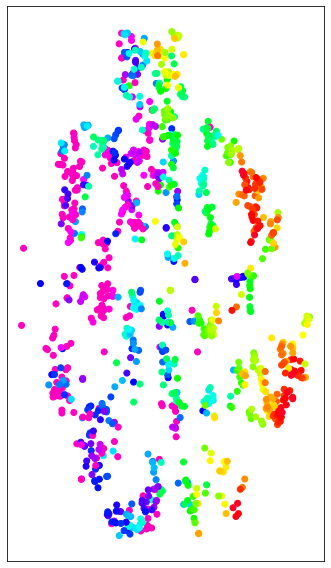

In [41]:
visualize_2(random_state=10, withbar=False)

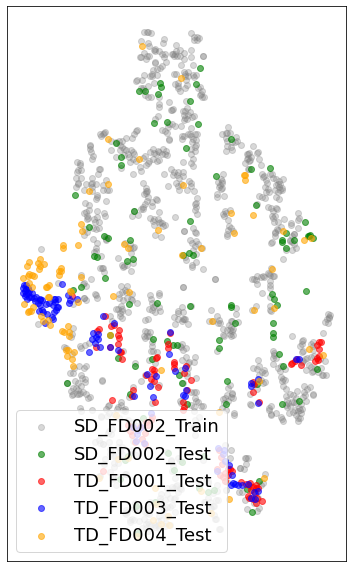

In [42]:
visualize_2(random_state=100, ood_mode=True, withbar=True)

## Downtream Task Training

In [43]:
def set_requires_grad(model, dict_, requires_grad=True):
    for param in model.named_parameters():
        if param[0] in dict_:
            param[1].requires_grad = requires_grad

In [44]:
model.load_state_dict(model_dict_org, strict=False)
model.train()
set_requires_grad(model, model_dict_org, requires_grad=True)

In [45]:
# for name, param in model.named_parameters():
#      print(f"{name} requires_grad: {param.requires_grad}")

In [46]:
# Freeze Encoder, fine-tune DownstreamTask Module and Feature Projection Module
for name, param in model.named_parameters():
    if 'feature_extractor.last' not in name:  
        param.requires_grad = False
    if  'feature_extractor.lastlayer' in name:
        param.requires_grad = True    
    if  'feature_extractor.last_third_layer' in name:
        param.requires_grad = True
    if  'feature_extractor.penultimate' in name:
        param.requires_grad = True

In [47]:

parameters = [
    {"params": filter(lambda p: p.requires_grad, model.parameters()), "lr": lrs[IN_IDX]},
]

optimizer1 = torch.optim.AdamW(parameters, weight_decay=lrs[IN_IDX])

epochs = 32 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# mode: Deterministic, Dropout, SNGP, DUE
trainer1 = Trainer(model=model,
                    model_optimizer=optimizer1,
                    print_every=50,
                    max_rul=RUL_UPPER_THRESHOLDS[IN_IDX],
                    epochs=epochs,
                    device=device,
                    prefix=DATASETS[IN_IDX],
                    mode=MODE,
                    criterion=loss_fn,
                    rep_mode = "fine_tuning"
                 ) 
best_score, best_RMSE = trainer1.train(train_loaders[IN_IDX], test_loaders[IN_IDX], 0)

Epoch: 1
batch:50/821, loss(avg. on 50 batches: 0.364410103559494
batch:100/821, loss(avg. on 50 batches: 0.2157484173774719
batch:150/821, loss(avg. on 50 batches: 0.14452914014458657
batch:200/821, loss(avg. on 50 batches: 0.11268960669636727
batch:250/821, loss(avg. on 50 batches: 0.09026405155658722
batch:300/821, loss(avg. on 50 batches: 0.0735878336429596
batch:350/821, loss(avg. on 50 batches: 0.060114190205931665
batch:400/821, loss(avg. on 50 batches: 0.05103927593678236
batch:450/821, loss(avg. on 50 batches: 0.04665292318910361
batch:500/821, loss(avg. on 50 batches: 0.04253357999026775
batch:550/821, loss(avg. on 50 batches: 0.03903633408248425
batch:600/821, loss(avg. on 50 batches: 0.03306333320215345
batch:650/821, loss(avg. on 50 batches: 0.03088259380310774
batch:700/821, loss(avg. on 50 batches: 0.030079624447971583
batch:750/821, loss(avg. on 50 batches: 0.030881592947989703
batch:800/821, loss(avg. on 50 batches: 0.02673881245777011
test result: score: 715.153015136

## Test Validation

In [48]:
#model_test.load_state_dict(test_state['state_dict'])
model_test = model
model_test.eval()
if MODE == "Dropout":
    model_test.train()

test(test_loaders[IN_IDX], model_test, RUL_UPPER_THRESHOLDS[IN_IDX], device="cuda", mode=MODE)   

{'rmse': 12.745882, 'mae': 9.175948, 'mape': 0.1686566, 'score': 727.34}
test result: score: 727.3400535583496, RMSE: 12.745882034301758


(727.3400535583496, tensor(12.7459, device='cuda:0'))

## Visualization after Fine-Tunning

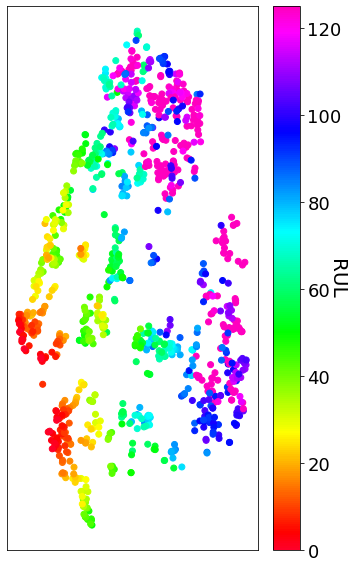

In [49]:
visualize_2(random_state=10)

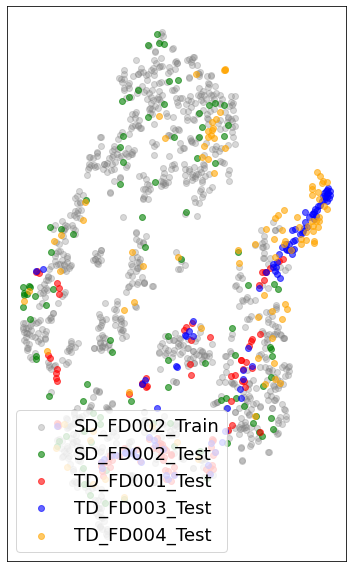

In [50]:
visualize_2(random_state=10, ood_mode=True)

## Zeroshot Transfer Learning

In [51]:
for idx in range(0,4):
    if IN_IDX != idx:
        print(DATASETS[idx])
        test(test_loaders[idx], model_test, RUL_UPPER_THRESHOLDS[idx], device="cuda", mode=MODE)  

FD001
{'rmse': 18.491138, 'mae': 13.468383, 'mape': 0.19082619, 'score': 429.41995}
test result: score: 429.41993713378906, RMSE: 18.49113655090332
FD003
{'rmse': 20.840836, 'mae': 16.051977, 'mape': 0.6360951, 'score': 1105.1307}
test result: score: 1105.1305847167969, RMSE: 20.840837478637695
FD004
{'rmse': 21.265875, 'mae': 15.253924, 'mape': 0.49208617, 'score': 4674.8945}
test result: score: 4674.894226074219, RMSE: 21.2658748626709


## Fine Tuning Transfer Learning

--------------- FD001 ---------------
Epoch: 1
batch:50/315, loss(avg. on 50 batches: 0.014376531802117825
batch:100/315, loss(avg. on 50 batches: 0.010987854450941087
batch:150/315, loss(avg. on 50 batches: 0.01155217151157558
batch:200/315, loss(avg. on 50 batches: 0.010203681848943234
batch:250/315, loss(avg. on 50 batches: 0.00975561154074967
batch:300/315, loss(avg. on 50 batches: 0.009695128928869963
test result: score: 211.59588623046875, RMSE: 11.995841026306152
Epoch: 2
batch:50/315, loss(avg. on 50 batches: 0.0097714535985142
batch:100/315, loss(avg. on 50 batches: 0.009815151896327734
batch:150/315, loss(avg. on 50 batches: 0.009066665857098997
batch:200/315, loss(avg. on 50 batches: 0.009023664169944823
batch:250/315, loss(avg. on 50 batches: 0.009257865222170949
batch:300/315, loss(avg. on 50 batches: 0.008758357875049114
test result: score: 210.79586791992188, RMSE: 11.100126266479492
best_score_checkpoints saved successfully!
best_RMSE_checkpoints saved successfully!
Epo

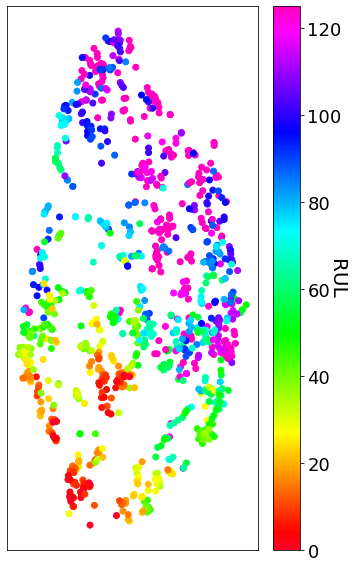

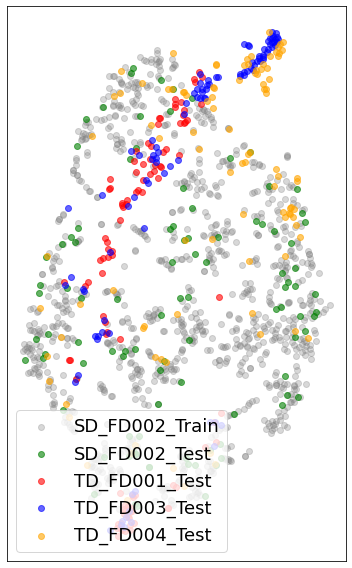

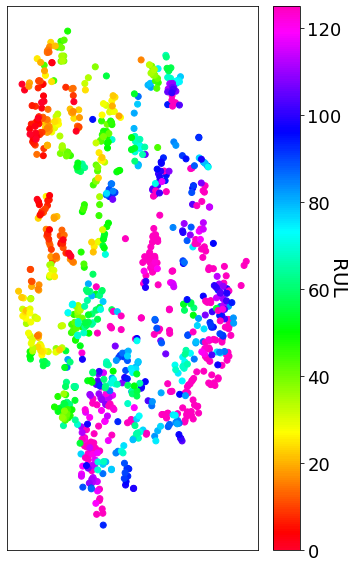

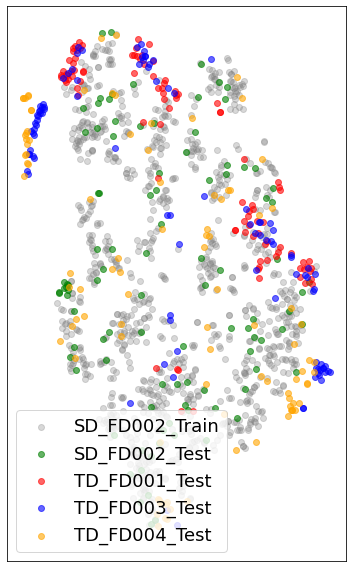

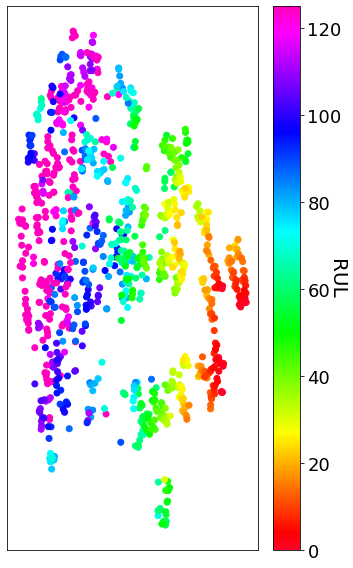

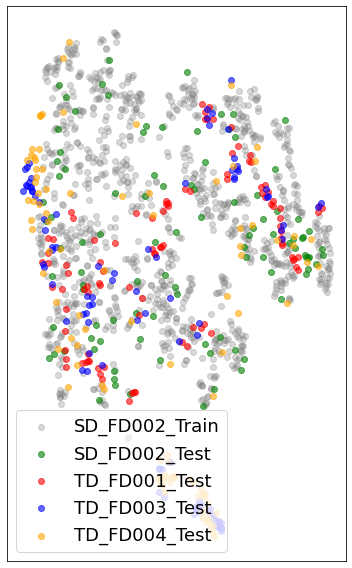

In [52]:
for idx in range(0,4):
    if IN_IDX != idx:
        print("---------------",DATASETS[idx],"---------------")
        model.train()
        model_dict = model.state_dict()
        set_requires_grad(model, model_dict, requires_grad=True)
        for name, param in model.named_parameters():
            if 'feature_extractor.last' not in name:  
                param.requires_grad = False
            if  'feature_extractor.lastlayer' in name:
                param.requires_grad = True    
            if  'feature_extractor.last_third_layer' in name:
                param.requires_grad = True
            if  'feature_extractor.penultimate' in name:
                param.requires_grad = True
        
        
        parameters = [
            {"params": filter(lambda p: p.requires_grad, model.parameters()), "lr": lrs[idx]},
        ]
        
        optimizer1 = torch.optim.AdamW(parameters, weight_decay=lrs[idx])
        
        epochs = 32 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # mode: Deterministic, Dropout, SNGP, DUE
        trainer1 = Trainer(model=model,
                            model_optimizer=optimizer1,
                            print_every=50,
                            max_rul=RUL_UPPER_THRESHOLDS[idx],
                            epochs=epochs,
                            device=device,
                            prefix=DATASETS[idx],
                            mode=MODE,
                            criterion=loss_fn,
                            rep_mode = "fine_tuning"
                         ) 
        best_score, best_RMSE = trainer1.train(train_loaders[idx], test_loaders[idx], 0) 

        visualize_2(random_state=10)
        visualize_2(random_state=10, ood_mode=True)
        

## Active Learning

In [72]:
if MODEL == "STAGNN":
    parameters = [
        {"params": filter(lambda p: p.requires_grad, model.parameters()), "lr": lrs[IN_IDX]/5},
    ]
    optimizer1 = torch.optim.AdamW(parameters, weight_decay=lrs[IN_IDX]/5)
    
if MODEL == "HSTRC":
    parameters = [
        {"params": filter(lambda p: p.requires_grad, model.parameters()), "lr": lrs[IN_IDX]*2},
    ]
    optimizer1 = torch.optim.AdamW(parameters, weight_decay=lrs[IN_IDX]*2)
    

epochs = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# mode: Deterministic, Dropout, SNGP, DUE
trainer2 = Trainer(model=model,
                    model_optimizer=optimizer1,
                    print_every=50,
                    max_rul=RUL_UPPER_THRESHOLDS[IN_IDX],
                    epochs=epochs,
                    device=device,
                    prefix=DATASETS[IN_IDX],
                    mode=MODE,
                    criterion=loss_fn,
                    rep_mode = "fine_tuning"
                 ) 
score_list, RMSE_list = trainer2.train_al(train_loaders[IN_IDX], test_loaders[IN_IDX], 0, sample_rate=0.02, al_iterations=10, reset_model_weights=model_dict_org)

------Active Learning Process Start: data_len 41019, samples_per_iteration 820,------
------Active Learning Iteration: 1------
Epoch: 1
test result: score: 444468.0625, RMSE: 74.69524383544922
Epoch: 2
test result: score: 100433.8046875, RMSE: 62.78974533081055
best_score got successfully! 100433.8046875
best_RMSE got successfully! 62.78974533081055
Epoch: 3
test result: score: 41851.82421875, RMSE: 54.9438362121582
best_score got successfully! 41851.82421875
best_RMSE got successfully! 54.9438362121582
Epoch: 4
test result: score: 20174.390625, RMSE: 47.44720458984375
best_score got successfully! 20174.390625
best_RMSE got successfully! 47.44720458984375
Epoch: 5
test result: score: 12949.203125, RMSE: 42.909881591796875
best_score got successfully! 12949.203125
best_RMSE got successfully! 42.909881591796875
Epoch: 6
test result: score: 8633.810546875, RMSE: 38.40336608886719
best_score got successfully! 8633.810546875
best_RMSE got successfully! 38.40336608886719
Epoch: 7
test result

In [73]:
score_list

[691.341796875,
 688.9764404296875,
 627.1693725585938,
 604.582275390625,
 595.7681274414062,
 565.86474609375,
 555.41015625,
 609.2671508789062,
 606.3190307617188,
 586.9125366210938]

In [74]:
RMSE_list

[13.511045455932617,
 13.532453536987305,
 12.76114273071289,
 12.69951057434082,
 12.410743713378906,
 12.121334075927734,
 12.296608924865723,
 12.426674842834473,
 12.733860969543457,
 11.851423263549805]

## Attention Visualization

<AxesSubplot:>

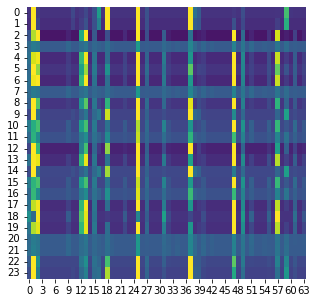

In [56]:
temproal_att = model_test.feature_extractor.tcn_2.network[1].x_probs[1].T
fig = plt.figure(figsize=(5,5))
#plt.matshow(temproal_att.cpu().detach().numpy(), vmin=0, vmax=0.03, fignum=1, aspect='auto')
sns.heatmap(temproal_att.cpu().detach().numpy(), vmin=0, vmax=0.05,cmap='viridis', cbar=False)
# plt.xlabel("Time Steps", fontsize=60)
# plt.ylabel("Sensor ID", fontsize=60)
# plt.xticks(fontsize=60)
# plt.yticks(fontsize=60)
#plt.tight_layout()
#plt.show()
#plt.savefig(os.path.join('./', f'image/HSTRC_{DATASETS[IN_IDX]}_Temporal_Att_Ref_Branch.pdf'))

<AxesSubplot:>

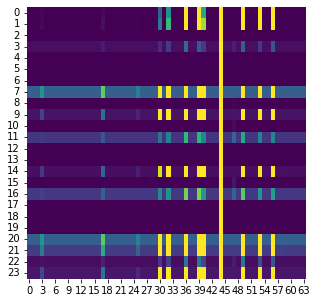

In [57]:
temproal_att = model_test.feature_extractor.tcn_1.network[1].x_probs[1].T
fig = plt.figure(figsize=(5,5))
#plt.matshow(temproal_att.cpu().detach().numpy(), vmin=0, vmax=0.03, fignum=1, aspect='auto')
sns.heatmap(temproal_att.cpu().detach().numpy(), vmin=0, vmax=0.03,cmap='viridis', cbar=False)
# plt.xlabel("Time Steps", fontsize=60)
# plt.ylabel("Sensor ID", fontsize=60)
# plt.xticks(fontsize=60)
# plt.yticks(fontsize=60)
#plt.tight_layout()
#plt.show()
#plt.savefig(os.path.join('./', f'image/HSTRC_{DATASETS[IN_IDX]}_Temporal_Att_Flip_Branch.pdf'))

## Sensitivity Analysis Visualization

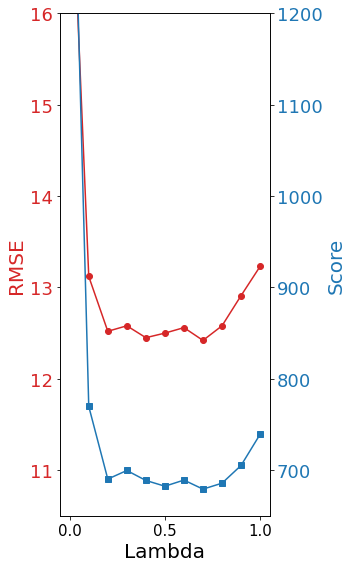

In [58]:
# Sample data
lambda_values = np.linspace(0, 1.0, 11)  # Lambda values from 0 to 1.0
rmse_values =   [18.08, 13.12, 12.52, 12.58, 12.45, 12.50, 12.56, 12.42, 12.58, 12.91, 13.23]  # Simulated RMSE values
score_values =  [1545.2,769.8, 690.2, 699.6, 688.7, 682.4, 689.1, 679.2, 685.7, 705.1, 739.2]  # Simulated Score values

fig, ax1 = plt.subplots(figsize=(5,8))

color = 'tab:red'
ax1.set_xlabel('Lambda', fontsize=20)
ax1.set_ylabel('RMSE', color=color, fontsize=20)
ax1.plot(lambda_values, rmse_values, color=color, marker='o', label='RMSE')
ax1.tick_params(axis='y', labelcolor=color,labelsize=18)
ax1.tick_params(axis='x', labelsize=15)
ax1.set_ylim((10.5,16))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Score', color=color, fontsize=20)  # we already handled the x-label with ax1
ax2.plot(lambda_values, score_values, color=color, marker='s', linestyle='-', label='Score')
ax2.tick_params(axis='y', labelcolor=color,labelsize=18)
ax2.set_ylim((650,1200))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig(os.path.join('./', f'image/HSTRC_lambda_visual.pdf')) 
#plt.show()

## Active Learning Visualization

In [59]:
score_list

[676.1528930664062,
 591.7716674804688,
 554.130126953125,
 604.09765625,
 669.4310302734375,
 620.1480102539062,
 640.7867431640625,
 628.37744140625,
 640.962158203125,
 660.9994506835938]

In [60]:
RMSE_list

[13.487688064575195,
 12.514185905456543,
 12.094071388244629,
 12.498175621032715,
 12.618476867675781,
 12.665194511413574,
 12.857267379760742,
 12.508082389831543,
 12.632360458374023,
 12.678287506103516]

In [61]:
FD002_Score_HSTRC = [705.3270263671875,
 658.2813720703125,
 600.3697509765625,
 606.57763671875,
 630.033203125,
 623.8777465820312,
 565.5758056640625,
 627.8414306640625,
 568.5946044921875,
 626.3464965820312]

FD002_RMSE_HSTRC = [14.139371871948242,
 13.224027633666992,
 12.826810836791992,
 12.866029739379883,
 12.744760513305664,
 12.799080848693848,
 12.353226661682129,
 12.584450721740723,
 12.324873924255371,
 12.547338485717773]

FD002_Score_HSTRC_1 = [928.9624633789062,
 686.197021484375,
 640.0767211914062,
 649.8392333984375,
 674.4540405273438,
 694.2645263671875,
 774.953857421875,
 753.3440551757812,
 707.2062377929688,
 702.0701293945312]

FD002_RMSE_HSTRC_1 = [15.221700668334961,
 13.607989311218262,
 12.96221923828125,
 12.929901123046875,
 12.719822883605957,
 12.757338523864746,
 13.14699649810791,
 13.054824829101562,
 12.91052532196045,
 12.76020622253418]

FD002_Score_HSTRC_2 = [780.6533203125,
 799.7789306640625,
 725.9151000976562,
 671.8037109375,
 729.785888671875,
 697.5528564453125,
 627.8435668945312,
 641.4008178710938,
 639.3951416015625,
 685.20458984375]

FD002_RMSE_HSTRC_2 = [14.004890441894531,
 13.782960891723633,
 13.382880210876465,
 13.079734802246094,
 13.156647682189941,
 12.87105941772461,
 12.823569297790527,
 12.36569881439209,
 13.027856826782227,
 12.678803443908691]

FD002_Score_HSTRC_3 = [848.8361206054688,
 836.8339233398438,
 770.8457641601562,
 737.8135986328125,
 746.9295654296875,
 740.5066528320312,
 697.1266479492188,
 643.836181640625,
 661.0034790039062,
 685.8099365234375]

FD002_RMSE_HSTRC_3 = [14.445331573486328,
 13.89261531829834,
 13.329263687133789,
 13.25001335144043,
 13.298480033874512,
 13.134391784667969,
 12.738932609558105,
 12.630427360534668,
 12.833224296569824,
 12.8030366897583]

FD002_Score_HSTRC_4 = [769.5066528320312,
 696.4056396484375,
 664.7423706054688,
 721.865234375,
 674.2725219726562,
 736.2024536132812,
 638.4819946289062,
 673.485107421875,
 657.3328857421875,
 668.7023315429688]

FD002_RMSE_HSTRC_4 = [14.52777099609375,
 13.360722541809082,
 13.611754417419434,
 13.213055610656738,
 13.160788536071777,
 13.327543258666992,
 12.848901748657227,
 12.726795196533203,
 12.333498001098633,
 12.863676071166992]

FD002_Score_HSTRC_5 = [801.9334716796875,
 692.654296875,
 651.9087524414062,
 655.1439819335938,
 609.3003540039062,
 684.566162109375,
 607.4391479492188,
 592.861328125,
 636.0931396484375,
 627.1577758789062]

FD002_RMSE_HSTRC_5 = [15.641829490661621,
 13.71249008178711,
 13.217255592346191,
 13.050957679748535,
 12.879854202270508,
 13.239825248718262,
 12.561484336853027,
 12.49312686920166,
 12.594951629638672,
 12.417638778686523]

FD002_Score_STAGNN = [2080.8505859375,
 1754.269775390625,
 1543.783203125,
 1107.2618408203125,
 1044.2042236328125,
 1099.693603515625,
 997.4572143554688,
 903.8010864257812,
 808.428466796875,
 819.6557006835938]

FD002_RMSE_STAGNN = [20.554542541503906,
 19.136406707763672,
 18.738588333129883,
 18.442951202392578,
 18.136341094970703,
 16.42172622680664,
 15.76235008239746,
 15.15815544128418,
 14.82059669494629,
 14.321438789367676]

FD002_Score_STAGNN_1 = [2524.138671875,
 1975.24853515625,
 1622.7537841796875,
 1187.6064453125,
 1160.2205810546875,
 849.69775390625,
 898.6348266601562,
 758.7821044921875,
 729.7885131835938,
 716.8272094726562]

FD002_RMSE_STAGNN_1 = [21.58211898803711,
 19.227113723754883,
 18.331375122070312,
 16.27617645263672,
 16.826351165771484,
 14.926560401916504,
 15.074509620666504,
 13.96624755859375,
 13.982924461364746,
 13.972787475585938]

FD002_Score_STAGNN_2 = [1991.67919921875,
 1777.203125,
 1318.56591796875,
 1250.911865234375,
 960.4263916015625,
 867.7550659179688,
 1017.9867553710938,
 814.4533081054688,
 830.1329345703125,
 886.5545654296875]

FD002_RMSE_STAGNN_2 = [21.340072631835938,
 20.05496597290039,
 18.822256088256836,
 16.471988677978516,
 15.542978286743164,
 14.890107154846191,
 15.540292739868164,
 14.42325210571289,
 14.712091445922852,
 14.418312072753906]

FD002_Score_STAGNN_3 = [2663.6455078125,
 1799.514892578125,
 1186.694580078125,
 1067.8138427734375,
 967.4811401367188,
 815.5250854492188,
 985.4783935546875,
 827.425537109375,
 775.7513427734375,
 838.161376953125]

FD002_RMSE_STAGNN_3 = [21.63600730895996,
 19.408456802368164,
 18.92188262939453,
 16.094959259033203,
 15.614253044128418,
 14.40864086151123,
 14.846672058105469,
 14.184305191040039,
 14.394586563110352,
 14.20048713684082]

FD002_Score_STAGNN_4 = [2600.756591796875,
 1919.374267578125,
 1308.5946044921875,
 1154.1878662109375,
 948.6312866210938,
 971.9185180664062,
 787.8603515625,
 841.921630859375,
 840.1464233398438,
 727.485595703125]

FD002_RMSE_STAGNN_4 = [21.351734161376953,
 19.443849563598633,
 18.178430557250977,
 17.076892852783203,
 16.31500244140625,
 15.503511428833008,
 14.466821670532227,
 14.439669609069824,
 14.912074089050293,
 14.108701705932617]

FD004_Score_HSTRC = [1579.6016845703125,
 1001.4108276367188,
 979.301025390625,
 966.5584716796875,
 859.0173950195312,
 911.7510375976562,
 841.3984375,
 852.349365234375,
 861.546142578125,
 826.7320556640625]

FD004_RMSE_HSTRC = [19.99970817565918,
 15.55332088470459,
 14.959792137145996,
 14.680574417114258,
 14.1228666305542,
 14.051169395446777,
 13.991032600402832,
 13.663374900817871,
 13.611855506896973,
 13.553587913513184]

FD004_Score_HSTRC_1 = [1579.6016845703125,
 1001.4108276367188,
 979.301025390625,
 966.5584716796875,
 859.0173950195312,
 911.7510375976562,
 841.3984375,
 852.349365234375,
 861.546142578125,
 826.7320556640625]

FD004_RMSE_HSTRC_1 = [16.427156448364258,
 15.262277603149414,
 14.098970413208008,
 13.717184066772461,
 13.899337768554688,
 13.98677921295166,
 13.918990135192871,
 13.81322193145752,
 13.57398796081543,
 13.297280311584473]

FD004_Score_HSTRC_2 = [1503.523681640625,
 1241.584716796875,
 1175.995849609375,
 1106.8946533203125,
 1091.43017578125,
 1051.2364501953125,
 916.48974609375,
 967.0344848632812,
 812.8502807617188,
 845.001220703125]

FD004_RMSE_HSTRC_2 = [17.69859504699707,
 15.894869804382324,
 15.399455070495605,
 14.495781898498535,
 14.245418548583984,
 14.21643352508545,
 13.816115379333496,
 13.633705139160156,
 13.453739166259766,
 13.243645668029785]

FD004_Score_HSTRC_3 = [1303.206787109375,
 1056.210205078125,
 978.6925048828125,
 893.557861328125,
 924.765380859375,                      
 855.5782470703125,
 820.7110595703125,
 813.7257080078125,
 805.5775756835938,
 802.4853515625]

FD004_RMSE_HSTRC_3 = [17.377490997314453,
 15.494406700134277,
 14.839293479919434,
 14.271891593933105,
 14.048678398132324,
 14.133500099182129,
 13.477993965148926,
 13.684752464294434,
 13.907157897949219,
 13.512446403503418]

FD004_Score_HSTRC_4 = [1327.2188720703125,
 1255.5096435546875,
 974.6689453125,
 886.4756469726562,
 946.9932861328125,
 879.6953735351562,
 759.3187866210938,
 832.8831787109375,
 827.0609130859375,
 848.0657348632812]

FD004_RMSE_HSTRC_4 = [17.09678077697754,
 15.782339096069336,
 15.01949691772461,
 14.369195938110352,
 14.403071403503418,
 14.193232536315918,
 13.597044944763184,
 13.802841186523438,
 13.859051704406738,
 13.628022193908691]

FD004_Score_STAGNN = [2286.154052734375,
 1655.8544921875,
 1229.24462890625,
 1171.546875,
 1120.341064453125,
 1098.005126953125,
 1045.9942626953125,
 1071.979248046875,
 986.90869140625,
 975.8204345703125]

FD004_RMSE_STAGNN = [22.354595184326172,
 18.949588775634766,
 17.28957176208496,
 16.279367446899414,
 16.36992073059082,
 15.92192611694336,
 15.710708618164062,
 15.329648971557617,
 14.778602600097656,
 14.65567970275879]

FD004_Score_STAGNN_1 = [3461.673583984375,
 1750.732421875,
 1861.813720703125,
 1654.302734375,
 1619.4677734375,
 1293.5244140625,
 1371.8995361328125,
 1266.32568359375,
 1167.9332275390625,
 1058.7684326171875]

FD004_RMSE_STAGNN_1 = [27.06813621520996,
 19.58385467529297,
 16.49590301513672,
 15.782058715820312,
 15.943307876586914,
 14.476991653442383,
 14.156694412231445,
 14.413576126098633,
 14.986221313476562,
 14.19141960144043]

FD004_Score_STAGNN_2 = [3033.55322265625,
 2086.426025390625,
 1737.53759765625,
 1156.99072265625,
 990.7218627929688,
 934.381103515625,
 873.5179443359375,
 849.0743408203125,
 854.7969360351562,
 834.2138061523438]

FD004_RMSE_STAGNN_2 = [26.054916381835938,
 19.312414169311523,
 15.745007514953613,
 15.538503646850586,
 14.783454895019531,
 14.517943382263184,
 14.103151321411133,
 14.125225067138672,
 14.102269172668457,
 13.917481422424316]

FD004_Score_STAGNN_3 = [2101.3828125,
 1728.8143310546875,
 1166.3935546875,
 937.3656005859375,
 968.0911865234375,
 850.8720703125,
 847.1852416992188,
 858.1478881835938,
 941.922119140625,
 856.15576171875]

FD004_RMSE_STAGNN_3 = [19.570026397705078,
 17.907301902770996,
 15.68558406829834,
 14.794052124023438,
 14.547212600708008,
 13.973003387451172,
 13.880159378051758,
 13.782649040222168,
 14.963088989257812,
 13.9098539352417]

FD004_Score_STAGNN_4 = [2040.349365234375,
 1528.6788330078125,
 1171.00537109375,
 999.181884765625,
 905.396240234375,
 884.3828735351562,
 872.1273193359375,
 854.0958862304688,
 878.321044921875,
 849.5343017578125]

FD004_RMSE_STAGNN_4 = [18.17696189880371,
 15.894685745239258,
 15.559449195861816,
 15.18373966217041,
 14.689199447631836,
 14.552902221679688,
 14.941610336303711,
 14.172338485717773,
 13.730961799621582,
 13.970826148986816]

FD004_Score_STAGNN_5 = [3007.890625,
 2046.99169921875,
 1987.33837890625,
 1204.00732421875,
 1152.39111328125,
 1269.39697265625,
 1033.3756103515625,
 995.538818359375,
 952.1586303710938,
 950.3842163085938]

FD004_RMSE_STAGNN_5 = [30.00664520263672,
 21.2331600189209,
 20.387067794799805,
 16.76492691040039,
 16.602535247802734,
 18.324012756347656,
 15.689043045043945,
 15.30609130859375,
 14.42648983001709,
 14.651384353637695]

FD004_Score_STAGNN_6 = [3803.31640625,
 2702.6907958984375,
 1671.425537109375,
 1171.3194580078125,
 1656.9482421875,
 1120.880126953125,
 892.2062377929688,
 935.56103515625,
 878.1439208984375,
 966.9078369140625]

FD004_RMSE_STAGNN_6 = [33.22099685668945,
 24.24974250793457,
 24.82967185974121,
 16.188074111938477,
 15.42745018005371,
 14.957030296325684,
 15.784531593322754,
 15.88578224182129,
 15.334301948547363,
 14.941033363342285]

FD004_Score_STAGNN_7 = [3485.546875,
 2572.04638671875,
 1619.308837890625,
 1104.9697265625,
 1390.9677734375,
 1094.5572509765625,
 939.4533081054688,
 961.1090087890625,
 967.496337890625,
 950.3931884765625]

FD004_RMSE_STAGNN_7 = [33.06018829345703,
 23.799041748046875,
 21.41114044189453,
 15.38245964050293,
 15.675621032714844,
 14.534408569335938,
 15.320618629455566,
 15.711475372314453,
 18.190717697143555,
 15.210403442382812]

FD004_Score_STAGNN_8 = [2942.90234375,
 1464.92041015625,
 1308.1014404296875,
 1693.14794921875,
 996.961181640625,
 1030.284912109375,
 940.63134765625,
 1107.0093994140625,
 946.847412109375,
 996.3472290039062]

FD004_RMSE_STAGNN_8 = [28.968990325927734,
 20.137836456298828,
 17.500150680541992,
 20.680496215820312,
 15.525800704956055,
 14.843782424926758,
 15.272594451904297,
 14.990457534790039,
 14.601217269897461,
 14.915701866149902]

In [62]:
FD004_RMSE_data_STAGNN = np.array([FD004_RMSE_STAGNN, FD004_RMSE_STAGNN_1, FD004_RMSE_STAGNN_2, FD004_RMSE_STAGNN_3, FD004_RMSE_STAGNN_4])
FD004_Score_data_STAGNN = np.array([FD004_Score_STAGNN, FD004_Score_STAGNN_1, FD004_Score_STAGNN_2, FD004_Score_STAGNN_3, FD004_Score_STAGNN_4])
FD004_RMSE_data_HSTRC = np.array([FD004_RMSE_HSTRC, FD004_RMSE_HSTRC_1, FD004_RMSE_HSTRC_2, FD004_RMSE_HSTRC_3, FD004_RMSE_HSTRC_4])
FD004_Score_data_HSTRC = np.array([FD004_Score_HSTRC, FD004_Score_HSTRC_1, FD004_Score_HSTRC_2, FD004_Score_HSTRC_3, FD004_Score_HSTRC_4])

In [63]:
FD004_RMSE_data_STAGNN = np.array([FD004_RMSE_STAGNN, FD004_RMSE_STAGNN_5, FD004_RMSE_STAGNN_6, FD004_RMSE_STAGNN_7, FD004_RMSE_STAGNN_8])
FD004_Score_data_STAGNN = np.array([FD004_Score_STAGNN, FD004_Score_STAGNN_5, FD004_Score_STAGNN_6, FD004_Score_STAGNN_7, FD004_Score_STAGNN_8])
FD004_RMSE_data_HSTRC = np.array([FD004_RMSE_HSTRC, FD004_RMSE_HSTRC_1, FD004_RMSE_HSTRC_2, FD004_RMSE_HSTRC_3, FD004_RMSE_HSTRC_4])
FD004_Score_data_HSTRC = np.array([FD004_Score_HSTRC, FD004_Score_HSTRC_1, FD004_Score_HSTRC_2, FD004_Score_HSTRC_3, FD004_Score_HSTRC_4])

In [64]:
FD004_RMSE_data_STAGNN_means = np.mean(FD004_RMSE_data_STAGNN, axis=0)
FD004_RMSE_data_STAGNN_variances = np.std(FD004_RMSE_data_STAGNN, axis=0)
FD004_Score_data_STAGNN_means = np.mean(FD004_Score_data_STAGNN, axis=0)
FD004_Score_data_STAGNN_variances = np.std(FD004_Score_data_STAGNN, axis=0)
FD004_RMSE_data_HSTRC_means = np.mean(FD004_RMSE_data_HSTRC, axis=0)
FD004_RMSE_data_HSTRC_variances = np.std(FD004_RMSE_data_HSTRC, axis=0)
FD004_Score_data_HSTRC_means = np.mean(FD004_Score_data_HSTRC, axis=0)
FD004_Score_data_HSTRC_variances = np.std(FD004_Score_data_HSTRC, axis=0)

In [65]:
FD002_RMSE_data_STAGNN = np.array([FD002_RMSE_STAGNN, FD002_RMSE_STAGNN_1, FD002_RMSE_STAGNN_2, FD002_RMSE_STAGNN_3, FD002_RMSE_STAGNN_4])
FD002_Score_data_STAGNN = np.array([FD002_Score_STAGNN, FD002_Score_STAGNN_1, FD002_Score_STAGNN_2, FD002_Score_STAGNN_3, FD002_Score_STAGNN_4])
FD002_RMSE_data_HSTRC = np.array([FD002_RMSE_HSTRC, FD002_RMSE_HSTRC_1, FD002_RMSE_HSTRC_2, FD002_RMSE_HSTRC_3, FD002_RMSE_HSTRC_4])
FD002_Score_data_HSTRC = np.array([FD002_Score_HSTRC, FD002_Score_HSTRC_1, FD002_Score_HSTRC_2, FD002_Score_HSTRC_3, FD002_Score_HSTRC_4])

In [66]:
FD002_RMSE_data_STAGNN_means = np.mean(FD002_RMSE_data_STAGNN, axis=0)
FD002_RMSE_data_STAGNN_variances = np.std(FD002_RMSE_data_STAGNN, axis=0)
FD002_Score_data_STAGNN_means = np.mean(FD002_Score_data_STAGNN, axis=0)
FD002_Score_data_STAGNN_variances = np.std(FD002_Score_data_STAGNN, axis=0)
FD002_RMSE_data_HSTRC_means = np.mean(FD002_RMSE_data_HSTRC, axis=0)
FD002_RMSE_data_HSTRC_variances = np.std(FD002_RMSE_data_HSTRC, axis=0)
FD002_Score_data_HSTRC_means = np.mean(FD002_Score_data_HSTRC, axis=0)
FD002_Score_data_HSTRC_variances = np.std(FD002_Score_data_HSTRC, axis=0)

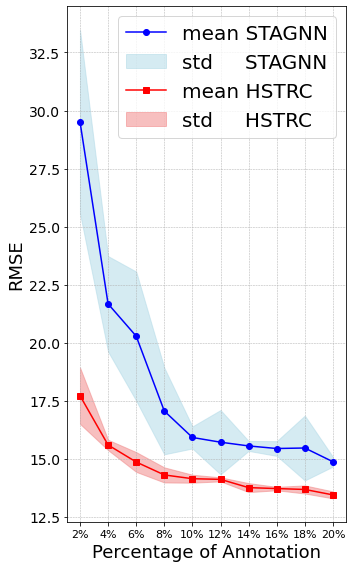

In [67]:
# Sample data for Active Learning visualization
al_rounds = np.arange(1, 11)  # 10 Active Learning rounds
stagnn_rmse = FD004_RMSE_data_STAGNN_means  # Simulated RMSE values for STAGNN
hstrc_rmse = FD004_RMSE_data_HSTRC_means  # Simulated RMSE values for HSTRC

stagnn_rmse_std = FD004_RMSE_data_STAGNN_variances  # Simulated RMSE values for STAGNN
hstrc_rmse_std = FD004_RMSE_data_HSTRC_variances  # Simulated RMSE values for HSTRC

# Plot
plt.figure(figsize=(5, 8))
plt.plot(al_rounds, stagnn_rmse, marker='o', linestyle='-', color='blue', label='mean STAGNN')
plt.fill_between(al_rounds, stagnn_rmse - stagnn_rmse_std, stagnn_rmse + stagnn_rmse_std, color='lightblue', alpha=0.5, label='std     STAGNN')
plt.plot(al_rounds, hstrc_rmse, marker='s', linestyle='-', color='red', label='mean HSTRC')
plt.fill_between(al_rounds, hstrc_rmse - hstrc_rmse_std, hstrc_rmse + hstrc_rmse_std, color='lightcoral', alpha=0.5, label='std     HSTRC')

plt.xlabel('Percentage of Annotation', fontsize=18)
plt.ylabel('RMSE', fontsize=18)
#plt.title('Active Learning RMSE Comparison: STAGNN vs HSTRC')
plt.xticks(al_rounds, labels=[f'{2 * i}%' for i in al_rounds],fontsize=11)  # Labeling x-axis with percentage of data annotated
plt.yticks(fontsize=14)
plt.legend(prop = { "size": 20 })
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig(os.path.join('./', f'image/AL_RMSE_{DATASETS[IN_IDX]}.pdf')) 
#plt.savefig(os.path.join('./', f'image/AL_RMSE_{DATASETS[3]}_1.pdf')) 

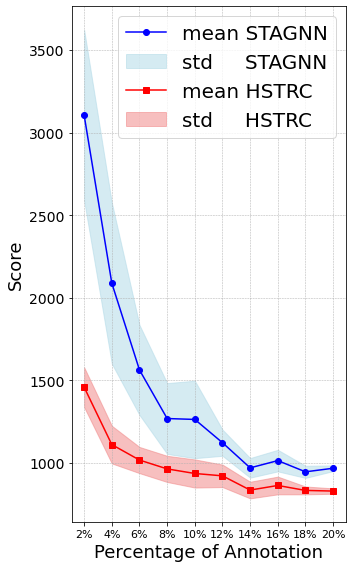

In [68]:
# Sample data for Active Learning visualization
al_rounds = np.arange(1, 11)  # 10 Active Learning rounds
stagnn_score = FD004_Score_data_STAGNN_means  # Simulated RMSE values for STAGNN
hstrc_score = FD004_Score_data_HSTRC_means  # Simulated RMSE values for HSTRC

stagnn_score_std = FD004_Score_data_STAGNN_variances  # Simulated RMSE values for STAGNN
hstrc_score_std = FD004_Score_data_HSTRC_variances  # Simulated RMSE values for HSTRC

# Plot
plt.figure(figsize=(5, 8))
plt.plot(al_rounds, stagnn_score, marker='o', linestyle='-', color='blue', label='mean STAGNN')
plt.fill_between(al_rounds, stagnn_score - stagnn_score_std, stagnn_score + stagnn_score_std, color='lightblue', alpha=0.5, label='std     STAGNN')
plt.plot(al_rounds, hstrc_score, marker='s', linestyle='-', color='red', label='mean HSTRC')
plt.fill_between(al_rounds, hstrc_score - hstrc_score_std, hstrc_score + hstrc_score_std, color='lightcoral', alpha=0.5, label='std     HSTRC')

plt.xlabel('Percentage of Annotation', fontsize=18)
plt.ylabel('Score', fontsize=18)
#plt.title('Active Learning RMSE Comparison: STAGNN vs HSTRC')
plt.xticks(al_rounds, labels=[f'{2 * i}%' for i in al_rounds],fontsize=11)  # Labeling x-axis with percentage of data annotated
plt.yticks(fontsize=14)
plt.legend(prop = { "size": 20 })
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig(os.path.join('./', f'image/AL_Score_{DATASETS[IN_IDX]}.pdf')) 
#plt.savefig(os.path.join('./', f'image/AL_Score_{DATASETS[3]}_1.pdf')) 

## OOD Visualization

In [69]:
def visualize_3(random_state=10, ood_mode=False, withbar=True):
    cm = plt.get_cmap('gist_rainbow')
    ood_colors = ['r', 'g', 'b', 'orange']
    z = np.load(f'./Result/{DATASETS[IN_IDX]}_Self_Sup.npy')
    y_tensor_in = torch.Tensor([trainsets[IN_IDX].y[0:1000]]).to(torch.float32).to("cuda")
    if withbar ==True:
        fig = plt.figure(figsize=(5,8))
    else:
        fig = plt.figure(figsize=(4.7,8))
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    if ood_mode==True:
        plt.scatter(z[:1000, 0], z[:1000, 1], c='gray', alpha=.3, label=f"SD_{DATASETS[IN_IDX]}_Train")
        for idx in range(0,4):
            start = 1000 + 100*idx
            end = 1000 + 100*(idx+1)
            if idx == IN_IDX:
                plt.scatter(z[start:end, 0], z[start:end, 1], c=ood_colors[idx], alpha=.6, label=f"SD_{DATASETS[idx]}_Test")
        for idx in range(0,4):
            start = 1000 + 100*idx
            end = 1000 + 100*(idx+1)
            if idx == IN_IDX:
                pass
            else: 
                plt.scatter(z[start:end, 0], z[start:end, 1], c=ood_colors[idx], alpha=.6, label=f"TD_{DATASETS[idx]}_Test")
        if withbar ==True:        
            plt.legend(prop = { "size": 18 }, loc='lower left')
    else:
        rul=y_tensor_in.detach().cpu().numpy().ravel()
        sc = plt.scatter(z[:1000, 0], z[:1000, 1], c=rul[:]*125, alpha=1, cmap='gist_rainbow')
        if withbar ==True:
            cbar = plt.colorbar(sc)
            cbar.set_label('RUL', rotation=270, size=20)
            cbar.ax.tick_params(labelsize=18) 
    plt.tight_layout() 
    if ood_mode==True:    
        #plt.savefig(os.path.join('./', f'image/HSTRC_{DATASETS[IN_IDX]}_ood.pdf')) 
        pass
    else:
        #plt.savefig(os.path.join('./', f'image/HSTRC_{DATASETS[IN_IDX]}_visual.pdf')) 
        pass

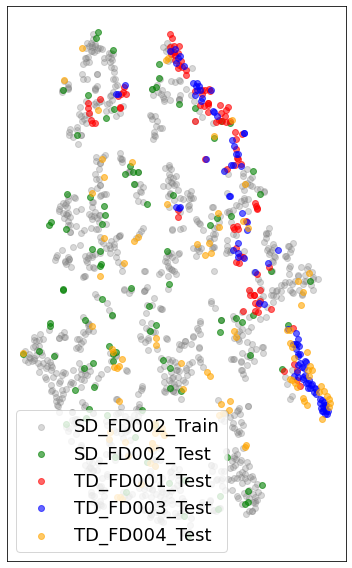

In [70]:
visualize_3(random_state=10, ood_mode=True, withbar=True)

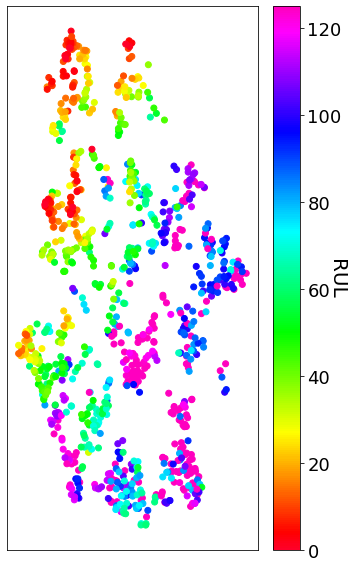

In [71]:
visualize_3(random_state=10, ood_mode=False, withbar=True)